# `DMKDE` performance on `pot_1`

In [1]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

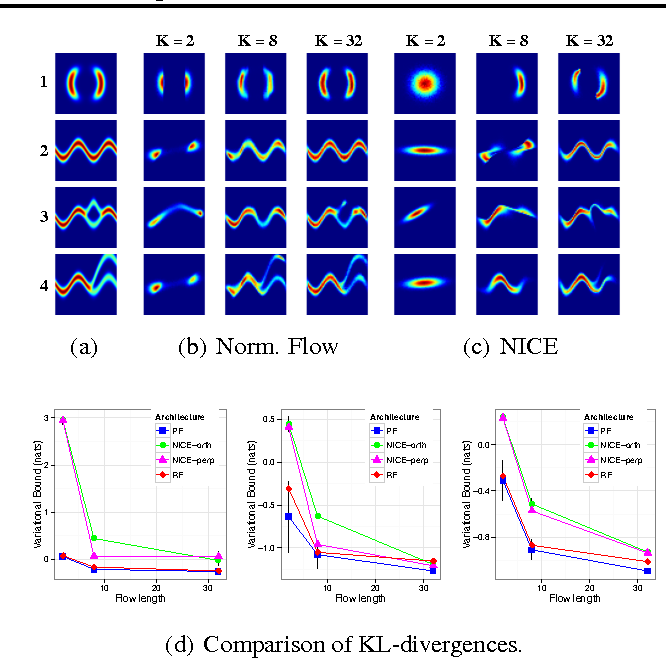

In [2]:
from IPython import display
display.Image("https://d3i71xaburhd42.cloudfront.net/0f899b92b7fb03b609fee887e4b6f3b633eaf30d/7-Figure3-1.png", width =666*0.5, height =658*0.5)

## About the libraries we need

Install `qmc`

Let´s install (git clone to the file system of the Colab VM) the module `qmc` which contains
> Custom models inherited from the super class `tf.keras.Model`.

> Custom layers inherited from the super class `tf.keras.layers.Layer`.

More information on customization when using `tf` this can be found at [here](https://www.tensorflow.org/tutorials/customization/custom_layers#models_composing_layers).

In [3]:
# Install qmc if running in Google Colab

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !rm -R qmc qmc1
    !git clone https://github.com/fagonzalezo/qmc.git
    !mv qmc qmc1
    !mv qmc1/qmc .
else:
    import sys
    sys.path.insert(0, "../")

rm: cannot remove 'qmc': No such file or directory
rm: cannot remove 'qmc1': No such file or directory
Cloning into 'qmc'...
remote: Enumerating objects: 516, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 516 (delta 46), reused 37 (delta 37), pack-reused 439
Receiving objects: 100% (516/516), 37.05 MiB | 14.35 MiB/s, done.
Resolving deltas: 100% (235/235), done.


Install `KDEpy`

In [4]:
pip install KDEpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 420 kB 4.9 MB/s 


Install `fastKDE`

In [5]:
pip install fastkde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 952 kB 5.0 MB/s 


General ones that include:

- `pandas` : For managing dataframes that come from txt files.
- `numpy` : For managing multidimensional arrays.
- `pylab` : For plotting purposes.

In [6]:
import pandas as pd
import numpy as np
import pylab as pl
from typeguard import typechecked
import tensorflow_probability as tfp
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
import tensorflow as tf
import qmc.tf.layers as layers
import qmc.tf.models as models
from scipy.stats import norm, bernoulli, gaussian_kde
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from KDEpy import NaiveKDE
from KDEpy import TreeKDE
from KDEpy import FFTKDE
from fastkde import fastKDE
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import seaborn as sns

 Clone repo for sampling made with Pytorch

In [7]:
# Install qmc if running in Google Colab

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !rm -R nf
    !git clone https://github.com/VishakhG/normalizing-flows nf
else:
    import sys
    sys.path.insert(0, "../")

rm: cannot remove 'nf': No such file or directory
Cloning into 'nf'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 49 (delta 12), reused 48 (delta 11), pack-reused 0
Unpacking objects: 100% (49/49), done.


In [8]:
import nf.src.densities as densitiesnf
import nf.src.normalizing_flows as nfs
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.autograd import Variable

In [9]:
params = {
   'axes.labelsize': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5]
   }
plt.rcParams.update(params)

## Auxiliary functions

Potential functions

In [ ]:
"""
Potential functions U(x) from Rezende et al. 2015
p(z) is then proportional to exp(-U(x)).
Since we log this value later in the optimized bound,
no need to actually exp().
"""

def w_1(z):
    return tf.sin((2 * np.pi * z[:, 0]) / 4)


def w_2(z):
    return 3 * tf.exp(-.5 * ((z[:, 0] - 1) / .6) ** 2)


def sigma(x):
    return 1 / (1 + tf.exp(- x))


def w_3(z):
    return 3 * sigma((z[:, 0] - 1) / .3)


def pot_1(z):
    z_1, z_2 = z[:, 0], z[:, 1]
    norm = tf.sqrt(z_1 ** 2 + z_2 ** 2)
    outer_term_1 = .5 * ((norm - 2) / .4) ** 2
    inner_term_1 = tf.exp((-.5 * ((z_1 - 2) / .6) ** 2))
    inner_term_2 = tf.exp((-.5 * ((z_1 + 2) / .6) ** 2))
    outer_term_2 = tf.math.log(inner_term_1 + inner_term_2 + 1e-7)
    u = outer_term_1 - outer_term_2
    return - u

Plot potential function

In [ ]:
def plot_pot_func(pot_func, ax=None):
    if ax is None:
        _, ax = plt.subplots(1)
    x = np.linspace(-4, 4, int(1e2))
    y = np.linspace(-4, 4, int(1e2))
    xx, yy = np.meshgrid(x, y)
    in_tens = tf.constant(np.vstack([xx.ravel(), yy.ravel()]).T)
    z = (tf.exp(pot_func(in_tens))).numpy().reshape(xx.shape)

    cmap = plt.get_cmap('inferno')
    ax.contourf(x, y, z.reshape(xx.shape), cmap=cmap)

Constant for `DMKDE` and `EIG_DMKDE` predictions

In [ ]:
def calculate_constant_qmkde(gamma=1, dimension = 1):
  sigma = (4*gamma)**(-1/2)
  coefficient = 1 /  (2*np.pi*sigma**2)**(dimension/2)
  return coefficient

Define `raw_kde` method 

In [ ]:
def raw_kde(x_test, x_train, gamma = 1):
  sigma = (2*gamma)**(-1/2)
  euclidean_distance = np.sum(((x_test-x_train))**2, axis=1)
  exponential  = np.exp(-euclidean_distance/(2*sigma**2))
  coefficient = 1 /  (2*np.pi*sigma**2)**(x_train.shape[1]/2) 
  constant_outside = 1/(x_train.shape[0]) * coefficient
  result = constant_outside * np.sum(exponential)  
  return result

## Data

Energy functions from `Variational Inference with Normalizing Flows`
***

See the article [here](http://proceedings.mlr.press/v37/rezende15.pdf) where the distribution of the data is given by the following equations:

1.
$$
\boxed{
\frac{1}{2}\left(\frac{\|\mathbf{z}\|-2}{0.4}\right)^{2}-\ln \left(e^{-\frac{1}{2}\left[\frac{\mathbf{z}_{1}-2}{0.6}\right]^{2}}+e^{-\frac{1}{2}\left[\frac{\mathbf{z}_{1}+2}{0.6}\right]^{2}}\right)}
$$
2.
$$
\frac{1}{2}\left[\frac{\mathbf{z}_{2}-w_{1}(\mathbf{z})}{0.4}\right]^{2}
$$
3.
$$
-\ln \left(e^{-\frac{1}{2}\left[\frac{\mathbf{z}_{2}-w_{1}(\mathbf{z})}{0.35}\right]^{2}}+e^{-\frac{1}{2}\left[\frac{\mathbf{z}_{2}-w_{1}(\mathbf{z})+w_{2}(\mathbf{z})}{0.35}\right]^{2}}\right)
$$
4.
$$
-\ln \left(e^{-\frac{1}{2}\left[\frac{\mathbf{z}_{2}-w_{1}(\mathbf{z})}{0.4}\right]^{2}}+e^{-\frac{1}{2}\left[\frac{\mathbf{z}_{2}-w_{1}(\mathbf{z})+w_{3}(\mathbf{z})}{0.35}\right]^{2}}\right)
$$

with $w_{1}(\mathbf{z})=\sin \left(\frac{2 \pi \mathbf{z}_{1}}{4}\right), w_{2}(\mathbf{z})=3 e^{-\frac{1}{2}\left[\frac{\left(\mathbf{z}_{1}-1\right)}{0.6}\right]^{2}}, w_{3}(\mathbf{z})=3 \sigma\left(\frac{\mathbf{z}_{1}-1}{0.3}\right) \text { and } \sigma(x)=\frac{1}{\left(1+e^{-x}\right)}$. 

Sample size

In [ ]:
sample_size = 1000000

Generate the sample

In [ ]:
@tf.function
def unnormalized_log_prob(x):  
  x = tf.reshape(x, (1,-1))
  res = pot_1(x)
  return res

# Initialize the HMC transition kernel.
num_results = int(sample_size)
num_burnin_steps = int(300)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_prob,
        num_leapfrog_steps=200,
        #unrolled_leapfrog_steps=2,
        state_gradients_are_stopped=False,
        step_size=np.array([0.01, 0.01])),
    num_adaptation_steps=int(num_burnin_steps * 0.9),
      target_accept_prob = 0.75)

# Run the chain (with burn-in).
@tf.function
def run_chain():
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=tf.constant([[-2.0,0.0]]),
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: [pkr.inner_results.is_accepted, 
                               #pkr.inner_results.accepted_results.step_size,
                             pkr.inner_results.log_accept_ratio])
  return samples, is_accepted

samples, is_accepted = run_chain()

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/__init__.py:75: UserWarning: TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The resulting loss of precision may hinder MCMC convergence. To turn off, run `tf.config.experimental.enable_tensor_float_32_execution(False)`. For more detail, see https://github.com/tensorflow/community/pull/287.
  'TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The '


In [ ]:
X = samples.numpy().reshape(num_results,2)

In [ ]:
X.shape

(1000000, 2)

Save data 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#np.savetxt(fname="/content/drive/MyDrive/UniversidadNacional/Thesis/Datasets/NF1/NF1_1M.csv", delimiter=" ", X = X)

Load data

In [ ]:
X = np.loadtxt("/content/drive/MyDrive/UniversidadNacional/Thesis/Datasets/NF1/NF1_1M.csv")

Plot of Potential 1 vs. Samples

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


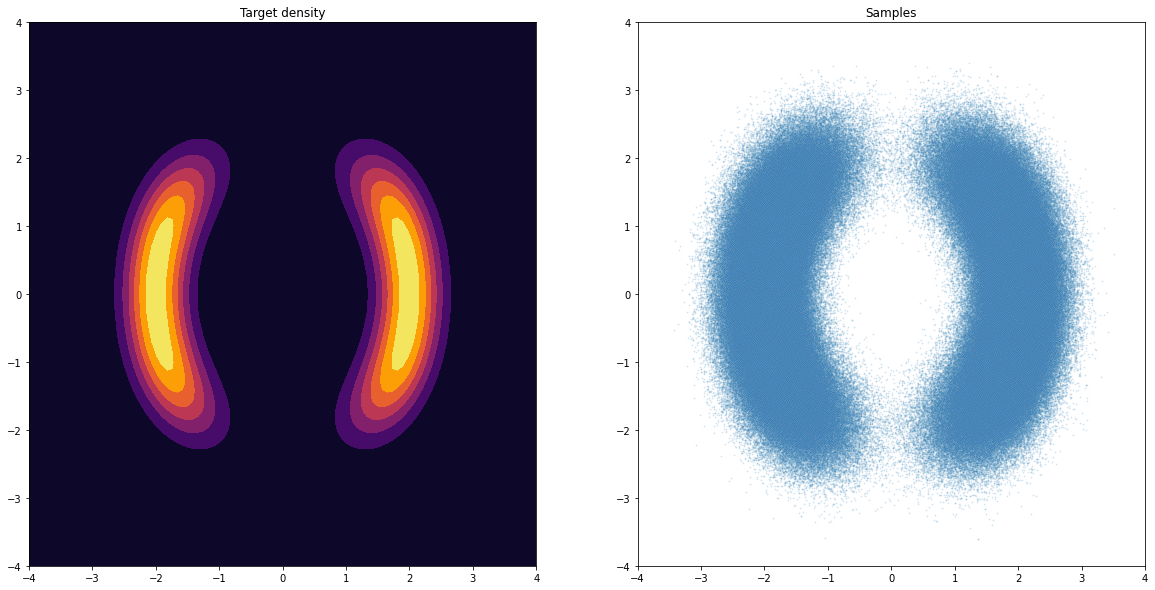

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat
plot_pot_func(pot_1, ax = axes[0]) 
axes[0].set_title('Target density')
axes[1].set_xlim([-4,4])
axes[1].set_ylim([-4,4])
sns.scatterplot(X[:, 0], X[:, 1], alpha=.2, s = 3 ,ax=axes[1])
axes[1].set_title('Samples')
plt.show()

True densities

In [ ]:
X_densities = np.exp(pot_1(X).numpy())/6.529

In [ ]:
X.shape

(1000000, 2)

In [ ]:
X_densities.shape

(1000000,)

Scatter plot of the data

In [ ]:
plt.rcParams["figure.figsize"] = (20*0.25,15*0.25)

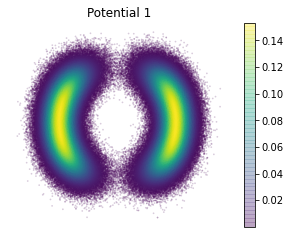

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X[:,0], X[:,1], c = X_densities , alpha = .2, s = 3, linewidths= 0.0000001)
plt.colorbar()
plt.title('Potential 1')
plt.yticks([])
plt.xticks([])
plt.savefig('alldensities_pot1.png',dpi = 300)
plt.show()

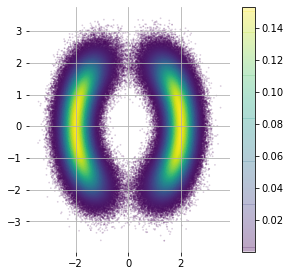

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X[:,0], X[:,1], c = X_densities, s = 3, alpha = .2, linewidths = 0.0000001)
plt.colorbar()
plt.show()

Histogram of distances with 1000 samples - Do not run



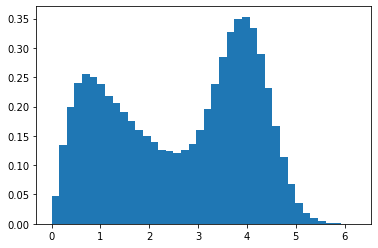

In [ ]:
#distances_X = euclidean_distances(X,X)
#plt.hist(distances_X[np.triu_indices_from(distances_X, k=1)].ravel(), density = True, bins=40);

We suggest a `bw = 1` or `bw = 4`.

## Experiment 1 : 10

Split data

In [ ]:
X_train, X_test, X_train_densities, X_test_densities  = train_test_split(X, X_densities, train_size = 10, test_size = 10000, random_state = 42)

In [ ]:
print(f'Train 2D data set shape is:{X_train.shape} and their densities shape is {X_train_densities.shape}')
print(f'Train 2D data set shape is:{X_test.shape} and their densities shape is {X_test_densities.shape}')

Train 2D data set shape is:(10, 2) and their densities shape is (10,)
Train 2D data set shape is:(10000, 2) and their densities shape is (10000,)


Scatter plot of test data

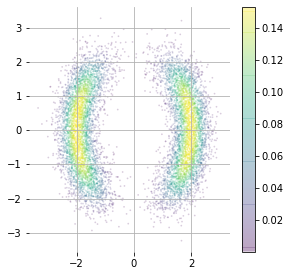

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = X_test_densities, alpha=.2,s = 3, linewidths= 0.0000001)
plt.colorbar()
plt.show()

### Fixing bandwidth

Cross Validation with 5 folds

In [ ]:
gammas = [2**i for i in range(-10,10,1)]
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
l1_error_means = []
for gamma in gammas: 
  l1_error = []
  #print(gamma) 
  # Mean of accuracy on the 5 folds wrt rawkde
  for train_index, test_index in kf.split(X_train[:,0]):
    X_train_new, X_test_new = X_train[train_index,:], X_train[test_index,:]
    X_test_real_densities = np.exp(pot_1(X_test_new).numpy())/6.529
    raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train_new , gamma = gamma) for xtest in X_test_new])    
    mae = 1 / X_test_real_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_real_densities))
    l1_error.append(mae)    
    #print(mae)
  #print('gamma:{} error:{}'.format(gamma,np.mean(l1_error)))
  l1_error_means.append(np.mean(l1_error))
print('Best gamma:{} with L1_error {}'.format(gammas[np.argmin(l1_error_means)],np.min(l1_error_means)))

Best gamma:2 with L1_error 0.047335069622557784


Fixed gamma

In [ ]:
gamma = 2

Fixed bandwidth

In [ ]:
bw = (np.sqrt(2*gamma))**(-1)

In [ ]:
bw

0.5

### Methods

#### `raw_kde`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'): 
  %time raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train , gamma = gamma) for xtest in X_test])

CPU times: user 174 ms, sys: 0 ns, total: 174 ms
Wall time: 177 ms


Scatter plot

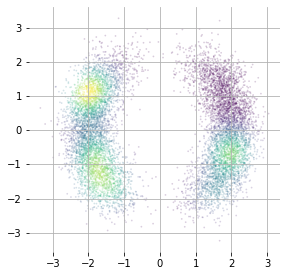

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = raw_kde_densities, alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_densities))

0.04268433378629392

#### `NaiveKDE`

Train

In [ ]:
NaiveKDE_density = NaiveKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time NaiveKDE_densities = NaiveKDE_density.evaluate(X_test)

CPU times: user 10.8 ms, sys: 642 µs, total: 11.4 ms
Wall time: 11.9 ms


Scatter plot

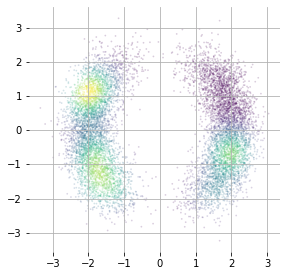

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = NaiveKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(NaiveKDE_densities - X_test_densities))

0.04268433378629385

#### `TreeKDE`

Train

In [ ]:
TreeKDE_density = TreeKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time TreeKDE_densities = TreeKDE_density.evaluate(X_test)

CPU times: user 3.18 s, sys: 2.41 ms, total: 3.18 s
Wall time: 3.16 s


Scatter plot

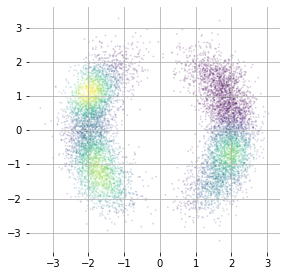

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = TreeKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(TreeKDE_densities - X_test_densities))

0.04268822523964256

#### `KernelDensity(algorithm = 'ball_tree')`

Train

In [ ]:
KernelDensitybt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'ball_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitybt_densities = np.exp(KernelDensitybt_density.score_samples(X_test))

CPU times: user 9.6 ms, sys: 832 µs, total: 10.4 ms
Wall time: 9.89 ms


Scatter plot

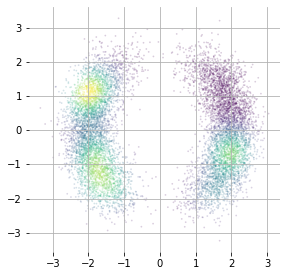

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitybt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitybt_densities - X_test_densities))

0.04268433378629392

#### `KernelDensity(algorithm = 'kd_tree')`

Train

In [ ]:
KernelDensitykdt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'kd_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitykdt_densities = np.exp(KernelDensitykdt_density.score_samples(X_test))

CPU times: user 12.5 ms, sys: 0 ns, total: 12.5 ms
Wall time: 11.9 ms


Scatter plot

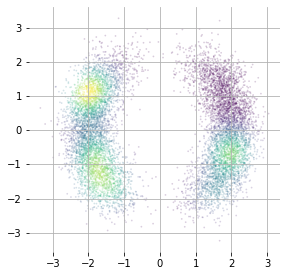

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitykdt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitykdt_densities - X_test_densities))

0.04268433378629392

#### `fastKDE`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time fastKDE_densities = fastKDE.pdf_at_points(X_train[:,0], X_train[:,1], list_of_points = X_test)

CPU times: user 3.94 s, sys: 0 ns, total: 3.94 s
Wall time: 3.92 s


Scatter plot

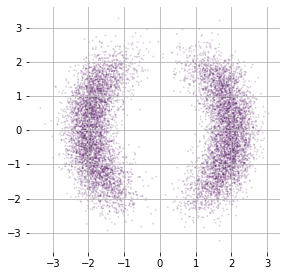

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = fastKDE_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(fastKDE_densities - X_test_densities))

0.07276545535772502

#### `DMKDE`

##### dim = 50

Train

In [ ]:
dim = 50
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_50 = models.QMDensity(fm_x, dim)
qmd_50.compile()
qmd_50.fit(X_train, epochs=1)

1/1 [==============================] - 3s 3s/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_50.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 706 ms, sys: 63.9 ms, total: 770 ms
Wall time: 649 ms


Scatter plot 

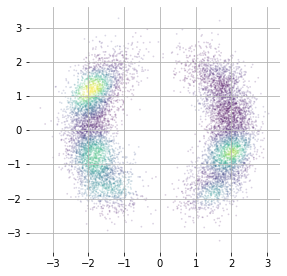

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.055060417245097734

##### dim = 100

Train

In [ ]:
dim = 100
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_100 = models.QMDensity(fm_x, dim)
qmd_100.compile()
qmd_100.fit(X_train, epochs=1)

1/1 [==============================] - 0s 72ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_100.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 1.71 s, sys: 81.4 ms, total: 1.79 s
Wall time: 1.35 s


Scatter plot 

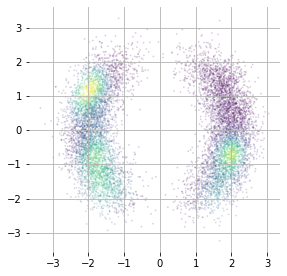

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.05961266739207458

##### dim = 500

Train

In [ ]:
dim = 500
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_500 = models.QMDensity(fm_x, dim)
qmd_500.compile()
qmd_500.fit(X_train, epochs=1)

1/1 [==============================] - 0s 78ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_500.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 1min 38s, sys: 2.21 s, total: 1min 40s
Wall time: 54.3 s


Scatter plot 

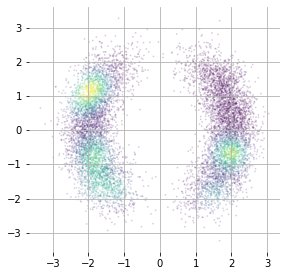

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.05749765432550603

##### dim = 1000

Train

In [ ]:
dim = 1000
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_1000 = models.QMDensity(fm_x, dim)
qmd_1000.compile()
qmd_1000.fit(X_train, epochs=1)

1/1 [==============================] - 0s 76ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_1000.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 10min 26s, sys: 4.22 s, total: 10min 30s
Wall time: 5min 25s


Scatter plot 

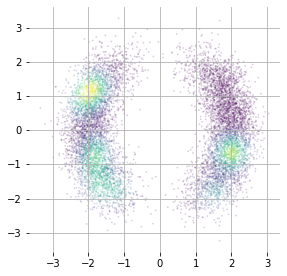

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.05755935925403587

#### `EIG-DMKDE`

##### dim = 50

Train

In [ ]:
num_eig = 50
dim = 50
sgd_model_50 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_50.set_rho(qmd_50.weights[2])

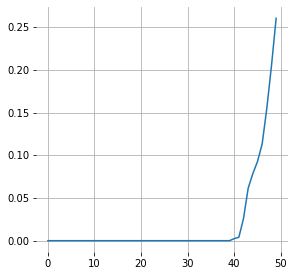

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_50.predict(X_test)

CPU times: user 482 ms, sys: 46.5 ms, total: 529 ms
Wall time: 396 ms


Scatter plot 

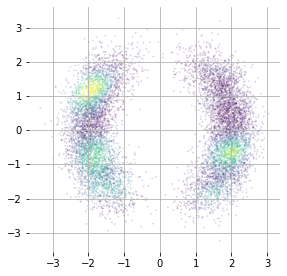

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.05506041331289084

##### dim = 100

Train

In [ ]:
num_eig = 50
dim = 100
sgd_model_100 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_100.set_rho(qmd_100.weights[2])

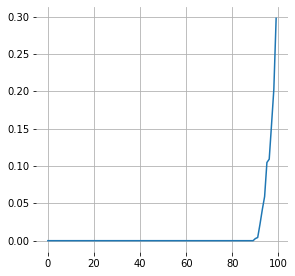

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_100.predict(X_test)

CPU times: user 496 ms, sys: 36.1 ms, total: 532 ms
Wall time: 388 ms


Scatter plot 

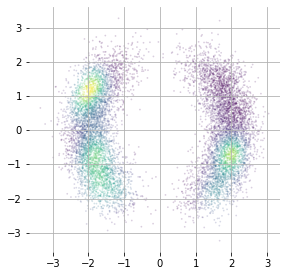

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.05961264618574315

##### dim = 500

Train

In [ ]:
num_eig = 50
dim = 500
sgd_model_500 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_500.set_rho(qmd_500.weights[2])

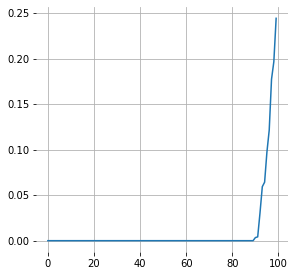

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_500.predict(X_test)

CPU times: user 541 ms, sys: 54.4 ms, total: 596 ms
Wall time: 450 ms


Scatter plot 

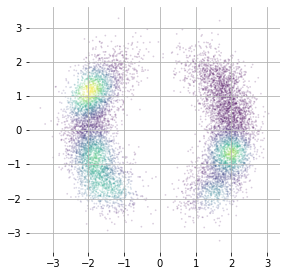

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.05749768956588641

##### dim = 1000

Train

In [ ]:
num_eig = 50
dim = 1000
sgd_model_1000 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_1000.set_rho(qmd_1000.weights[2])

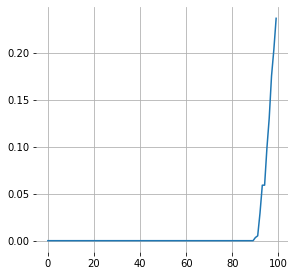

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_1000.predict(X_test)

CPU times: user 776 ms, sys: 72.5 ms, total: 848 ms
Wall time: 597 ms


Scatter plot 

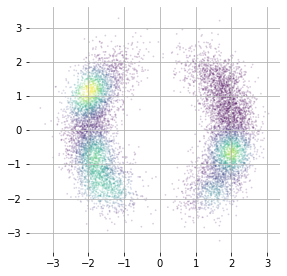

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.05755988737423736

## Experiment 2 : 100

Split data

In [ ]:
X_train, X_test, X_train_densities, X_test_densities  = train_test_split(X, X_densities, train_size = 100, test_size = 10000, random_state = 42)

In [ ]:
print(f'Train 2D data set shape is:{X_train.shape} and their densities shape is {X_train_densities.shape}')
print(f'Train 2D data set shape is:{X_test.shape} and their densities shape is {X_test_densities.shape}')

Train 2D data set shape is:(100, 2) and their densities shape is (100,)
Train 2D data set shape is:(10000, 2) and their densities shape is (10000,)


Scatter plot of test data

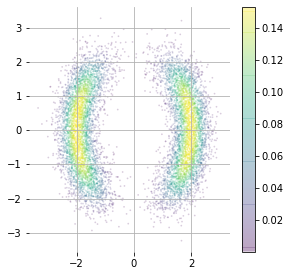

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = X_test_densities, alpha=.2,s = 3, linewidths= 0.0000001)
plt.colorbar()
plt.show()

### Fixing bandwidth

Cross Validation with 5 folds

In [ ]:
gammas = [2**i for i in range(-10,10,1)]
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
l1_error_means = []
for gamma in gammas: 
  l1_error = []
  #print(gamma) 
  # Mean of accuracy on the 5 folds wrt rawkde
  for train_index, test_index in kf.split(X_train[:,0]):
    X_train_new, X_test_new = X_train[train_index,:], X_train[test_index,:]
    X_test_real_densities = np.exp(pot_1(X_test_new).numpy())/6.529
    raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train_new , gamma = gamma) for xtest in X_test_new])    
    mae = 1 / X_test_real_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_real_densities))
    l1_error.append(mae)    
    #print(mae)
  #print('gamma:{} error:{}'.format(gamma,np.mean(l1_error)))
  l1_error_means.append(np.mean(l1_error))
print('Best gamma:{} with L1_error {}'.format(gammas[np.argmin(l1_error_means)],np.min(l1_error_means)))

Best gamma:8 with L1_error 0.025940176999645775


Fixed gamma

In [ ]:
gamma = 8

Fixed bandwidth

In [ ]:
bw = (np.sqrt(2*gamma))**(-1)

In [ ]:
bw

0.25

### Methods

#### `raw_kde`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'): 
  %time raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train , gamma = gamma) for xtest in X_test])

CPU times: user 212 ms, sys: 3.06 ms, total: 215 ms
Wall time: 215 ms


Scatter plot

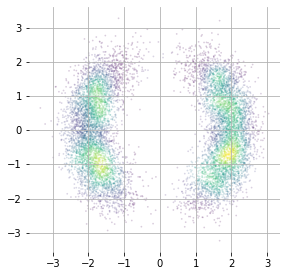

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = raw_kde_densities, alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_densities))

0.02322747530948575

#### `NaiveKDE`

Train

In [ ]:
NaiveKDE_density = NaiveKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time NaiveKDE_densities = NaiveKDE_density.evaluate(X_test)

CPU times: user 78.6 ms, sys: 1.94 ms, total: 80.5 ms
Wall time: 82.6 ms


Scatter plot

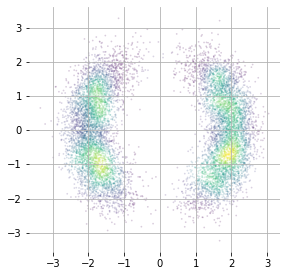

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = NaiveKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(NaiveKDE_densities - X_test_densities))

0.02322747530948569

#### `TreeKDE`

Train

In [ ]:
TreeKDE_density = TreeKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time TreeKDE_densities = TreeKDE_density.evaluate(X_test)

CPU times: user 3.26 s, sys: 32.5 ms, total: 3.29 s
Wall time: 3.28 s


Scatter plot

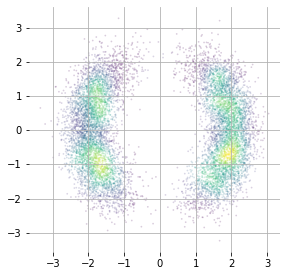

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = TreeKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(TreeKDE_densities - X_test_densities))

0.023232472284887236

#### `KernelDensity(algorithm = 'ball_tree')`

Train

In [ ]:
KernelDensitybt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'ball_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitybt_densities = np.exp(KernelDensitybt_density.score_samples(X_test))

CPU times: user 71.1 ms, sys: 3.05 ms, total: 74.2 ms
Wall time: 74.9 ms


Scatter plot

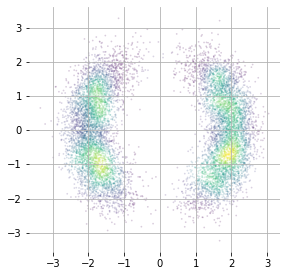

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitybt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitybt_densities - X_test_densities))

0.02322747530948575

#### `KernelDensity(algorithm = 'kd_tree')`

Train

In [ ]:
KernelDensitykdt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'kd_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitykdt_densities = np.exp(KernelDensitykdt_density.score_samples(X_test))

CPU times: user 60.3 ms, sys: 0 ns, total: 60.3 ms
Wall time: 60.8 ms


Scatter plot

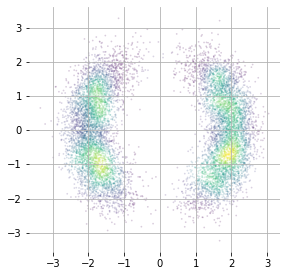

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitykdt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitykdt_densities - X_test_densities))

0.02322747530948575

#### `fastKDE`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time fastKDE_densities = fastKDE.pdf_at_points(X_train[:,0], X_train[:,1], list_of_points = X_test)

CPU times: user 7.78 s, sys: 9.32 ms, total: 7.79 s
Wall time: 7.78 s


Scatter plot

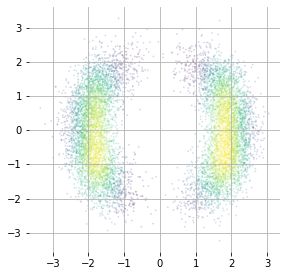

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = fastKDE_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(fastKDE_densities - X_test_densities))

0.024989424053013097

#### `DMKDE`

##### dim = 50

Train

In [ ]:
dim = 50
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_50 = models.QMDensity(fm_x, dim)
qmd_50.compile()
qmd_50.fit(X_train, epochs=1)

4/4 [==============================] - 0s 2ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_50.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 663 ms, sys: 443 ms, total: 1.11 s
Wall time: 955 ms


Scatter plot 

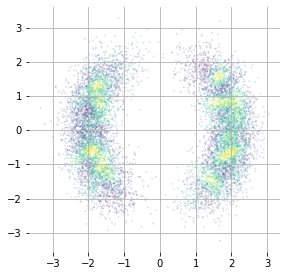

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.08093809686590595

##### dim = 100

Train

In [ ]:
dim = 100
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_100 = models.QMDensity(fm_x, dim)
qmd_100.compile()
qmd_100.fit(X_train, epochs=1)

4/4 [==============================] - 0s 3ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_100.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 1.72 s, sys: 306 ms, total: 2.03 s
Wall time: 1.57 s


Scatter plot 

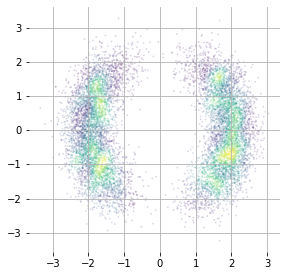

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.05407337251441277

##### dim = 500

Train

In [ ]:
dim = 500
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_500 = models.QMDensity(fm_x, dim)
qmd_500.compile()
qmd_500.fit(X_train, epochs=1)

4/4 [==============================] - 0s 3ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_500.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 1min 40s, sys: 6.46 s, total: 1min 46s
Wall time: 59.3 s


Scatter plot 

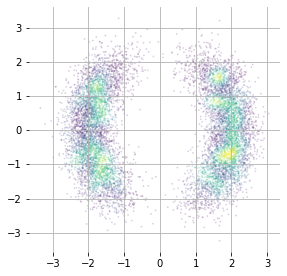

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.03246992986090464

##### dim = 1000

Train

In [ ]:
dim = 1000
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_1000 = models.QMDensity(fm_x, dim)
qmd_1000.compile()
qmd_1000.fit(X_train, epochs=1)

4/4 [==============================] - 0s 4ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_1000.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 10min 40s, sys: 8.28 s, total: 10min 48s
Wall time: 5min 36s


Scatter plot 

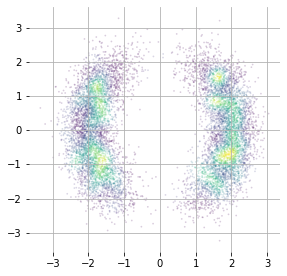

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.03278495634129457

#### `EIG-DMKDE`

##### dim = 50

Train

In [ ]:
num_eig = 50
dim = 50
sgd_model_50 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_50.set_rho(qmd_50.weights[2])

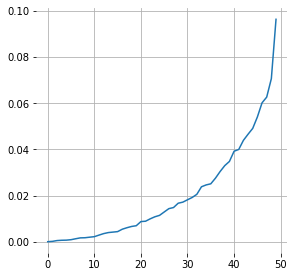

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_50.predict(X_test)

CPU times: user 494 ms, sys: 45 ms, total: 539 ms
Wall time: 399 ms


Scatter plot 

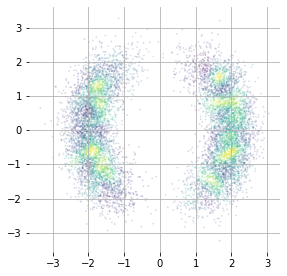

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.08093809055675429

##### dim = 100

Train

In [ ]:
num_eig = 100
dim = 100
sgd_model_100 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_100.set_rho(qmd_100.weights[2])

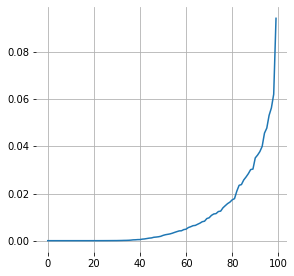

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_100.predict(X_test)

CPU times: user 539 ms, sys: 42.8 ms, total: 581 ms
Wall time: 448 ms


Scatter plot 

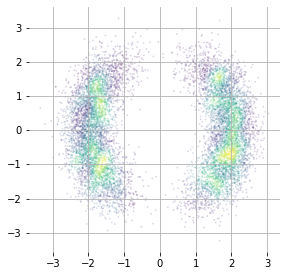

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.054073382773862255

##### dim = 500

Train

In [ ]:
num_eig = 100
dim = 500
sgd_model_500 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_500.set_rho(qmd_500.weights[2])

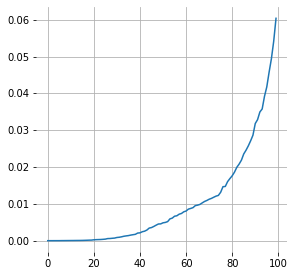

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_500.predict(X_test)

CPU times: user 788 ms, sys: 403 ms, total: 1.19 s
Wall time: 925 ms


Scatter plot 

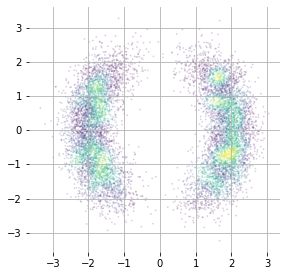

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.03246997273173166

##### dim = 1000

Train

In [ ]:
num_eig = 100
dim = 1000
sgd_model_1000 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_1000.set_rho(qmd_1000.weights[2])

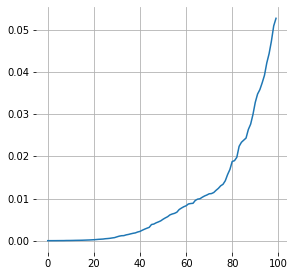

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_1000.predict(X_test)

CPU times: user 987 ms, sys: 454 ms, total: 1.44 s
Wall time: 1.11 s


Scatter plot 

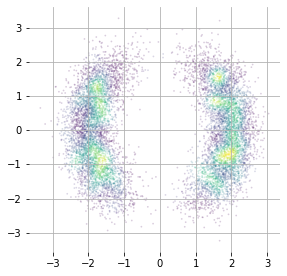

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.032785304253350016

## Experiment 3 : 1000

Split data

In [ ]:
X_train, X_test, X_train_densities, X_test_densities  = train_test_split(X, X_densities, train_size = 1000, test_size = 10000, random_state = 42)

In [ ]:
print(f'Train 2D data set shape is:{X_train.shape} and their densities shape is {X_train_densities.shape}')
print(f'Train 2D data set shape is:{X_test.shape} and their densities shape is {X_test_densities.shape}')

Train 2D data set shape is:(1000, 2) and their densities shape is (1000,)
Train 2D data set shape is:(10000, 2) and their densities shape is (10000,)


Scatter plot of test data

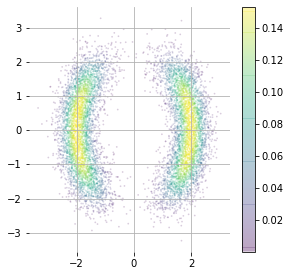

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = X_test_densities, alpha=.2,s = 3, linewidths= 0.0000001)
plt.colorbar()
plt.show()

### Fixing bandwidth

Cross Validation with 5 folds

In [ ]:
gammas = [2**i for i in range(-10,10,1)]
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
l1_error_means = []
for gamma in gammas: 
  l1_error = []
  #print(gamma) 
  # Mean of accuracy on the 5 folds wrt rawkde
  for train_index, test_index in kf.split(X_train[:,0]):
    X_train_new, X_test_new = X_train[train_index,:], X_train[test_index,:]
    X_test_real_densities = np.exp(pot_1(X_test_new).numpy())/6.529
    raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train_new , gamma = gamma) for xtest in X_test_new])    
    mae = 1 / X_test_real_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_real_densities))
    l1_error.append(mae)    
    #print(mae)
  #print('gamma:{} error:{}'.format(gamma,np.mean(l1_error)))
  l1_error_means.append(np.mean(l1_error))
print('Best gamma:{} with L1_error {}'.format(gammas[np.argmin(l1_error_means)],np.min(l1_error_means)))

Best gamma:16 with L1_error 0.01557619851108776


Fixed gamma

In [ ]:
gamma = 16

Fixed bandwidth

In [ ]:
bw = (np.sqrt(2*gamma))**(-1)

In [ ]:
bw

0.17677669529663687

### Methods

#### `raw_kde`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'): 
  %time raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train , gamma = gamma) for xtest in X_test])

CPU times: user 605 ms, sys: 3.94 ms, total: 609 ms
Wall time: 634 ms


Scatter plot

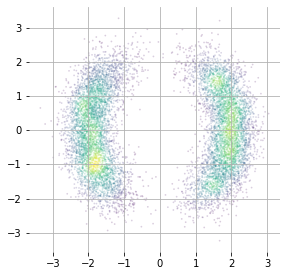

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = raw_kde_densities, alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_densities))

0.01486045667178552

#### `NaiveKDE`

Train

In [ ]:
NaiveKDE_density = NaiveKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time NaiveKDE_densities = NaiveKDE_density.evaluate(X_test)

CPU times: user 753 ms, sys: 0 ns, total: 753 ms
Wall time: 761 ms


Scatter plot

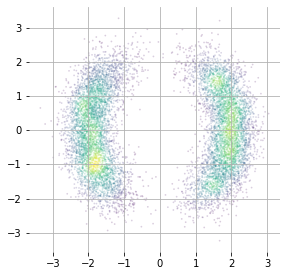

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = NaiveKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(NaiveKDE_densities - X_test_densities))

0.014860456671785463

#### `TreeKDE`

Train

In [ ]:
TreeKDE_density = TreeKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time TreeKDE_densities = TreeKDE_density.evaluate(X_test)

CPU times: user 3.67 s, sys: 36.7 ms, total: 3.71 s
Wall time: 3.72 s


Scatter plot

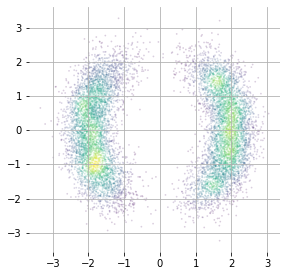

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = TreeKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(TreeKDE_densities - X_test_densities))

0.014866615837217788

#### `KernelDensity(algorithm = 'ball_tree')`

Train

In [ ]:
KernelDensitybt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'ball_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitybt_densities = np.exp(KernelDensitybt_density.score_samples(X_test))

CPU times: user 540 ms, sys: 898 µs, total: 541 ms
Wall time: 541 ms


Scatter plot

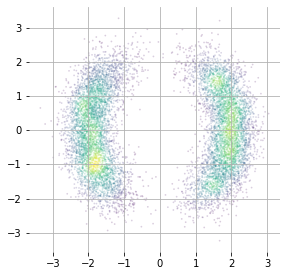

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitybt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitybt_densities - X_test_densities))

0.014860456671785677

#### `KernelDensity(algorithm = 'kd_tree')`

Train

In [ ]:
KernelDensitykdt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'kd_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitykdt_densities = np.exp(KernelDensitykdt_density.score_samples(X_test))

CPU times: user 558 ms, sys: 808 µs, total: 559 ms
Wall time: 559 ms


Scatter plot

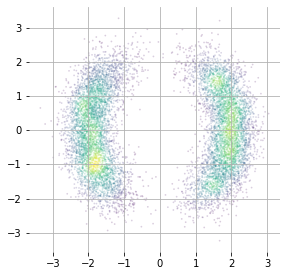

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitykdt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitykdt_densities - X_test_densities))

0.014860456671785798

#### `fastKDE`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time fastKDE_densities = fastKDE.pdf_at_points(X_train[:,0], X_train[:,1], list_of_points = X_test)

CPU times: user 15.5 s, sys: 20 ms, total: 15.5 s
Wall time: 15.4 s


Scatter plot

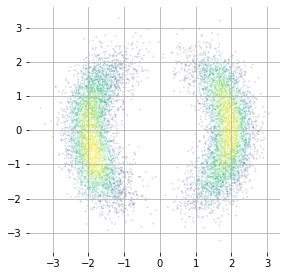

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = fastKDE_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(fastKDE_densities - X_test_densities))

0.009835923616732195

#### `DMKDE`

##### dim = 50

Train

In [ ]:
dim = 50
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_50 = models.QMDensity(fm_x, dim)
qmd_50.compile()
qmd_50.fit(X_train, epochs=1)

32/32 [==============================] - 0s 1ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_50.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 674 ms, sys: 43.4 ms, total: 718 ms
Wall time: 578 ms


Scatter plot 

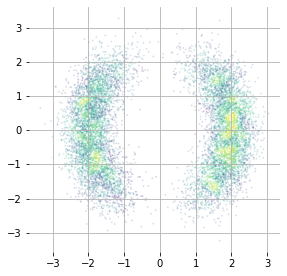

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.18814982380164036

##### dim = 100

Train

In [ ]:
dim = 100
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_100 = models.QMDensity(fm_x, dim)
qmd_100.compile()
qmd_100.fit(X_train, epochs=1)

32/32 [==============================] - 0s 925us/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_100.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 1.78 s, sys: 710 ms, total: 2.49 s
Wall time: 2.05 s


Scatter plot 

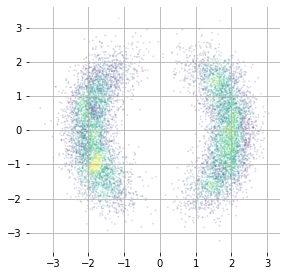

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.09460048184569395

##### dim = 500

Train

In [ ]:
dim = 500
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_500 = models.QMDensity(fm_x, dim)
qmd_500.compile()
qmd_500.fit(X_train, epochs=1)

32/32 [==============================] - 0s 974us/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_500.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 1min 39s, sys: 15.5 s, total: 1min 55s
Wall time: 1min 7s


Scatter plot 

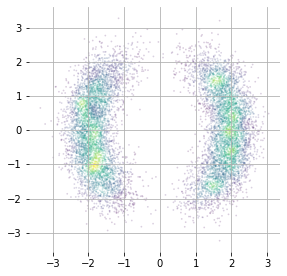

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.01978312386718648

##### dim = 1000

Train

In [ ]:
dim = 1000
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_1000 = models.QMDensity(fm_x, dim)
qmd_1000.compile()
qmd_1000.fit(X_train, epochs=1)

32/32 [==============================] - 0s 2ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_1000.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 10min 41s, sys: 8.96 s, total: 10min 50s
Wall time: 5min 37s


Scatter plot 

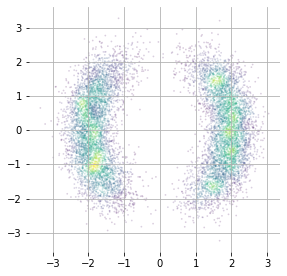

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.01787744918106744

#### `EIG-DMKDE`

##### dim = 50

Train

In [ ]:
num_eig = 50
dim = 50
sgd_model_50 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_50.set_rho(qmd_50.weights[2])

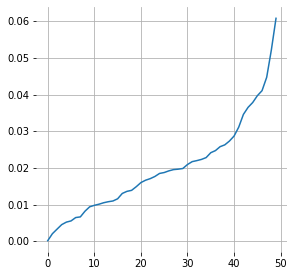

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_50.predict(X_test)

CPU times: user 495 ms, sys: 37.8 ms, total: 533 ms
Wall time: 412 ms


Scatter plot 

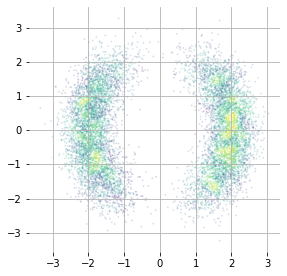

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.18814986553979288

##### dim = 100

Train

In [ ]:
num_eig = 100
dim = 100
sgd_model_100 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_100.set_rho(qmd_100.weights[2])

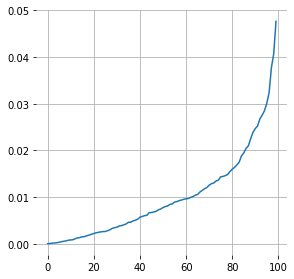

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_100.predict(X_test)

CPU times: user 535 ms, sys: 41.4 ms, total: 577 ms
Wall time: 431 ms


Scatter plot 

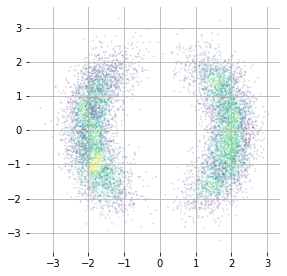

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.09460052017297065

##### dim = 500

Train

In [ ]:
num_eig = 300
dim = 500
sgd_model_500 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_500.set_rho(qmd_500.weights[2])

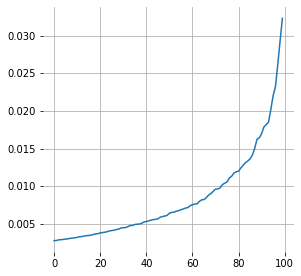

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_500.predict(X_test)

CPU times: user 1.85 s, sys: 1.14 s, total: 2.99 s
Wall time: 2.34 s


Scatter plot 

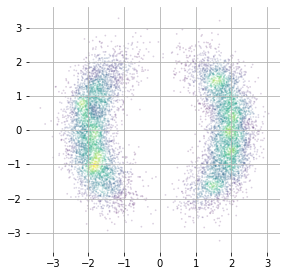

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.019784102639901213

##### dim = 1000

Train

In [ ]:
num_eig = 300
dim = 1000
sgd_model_1000 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_1000.set_rho(qmd_1000.weights[2])

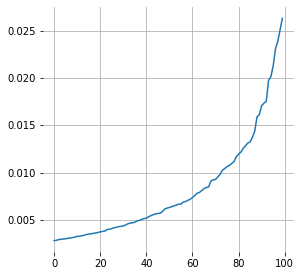

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_1000.predict(X_test)

CPU times: user 2.73 s, sys: 1.19 s, total: 3.93 s
Wall time: 2.81 s


Scatter plot 

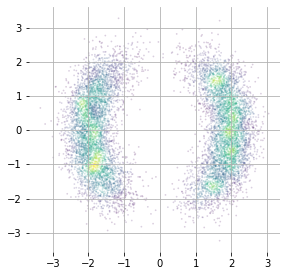

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.017882284164399014

## Experiment 4 : 10000

Split data

In [ ]:
X_train, X_test, X_train_densities, X_test_densities  = train_test_split(X, X_densities, train_size = 10000, test_size = 10000, random_state = 42)

In [ ]:
print(f'Train 2D data set shape is:{X_train.shape} and their densities shape is {X_train_densities.shape}')
print(f'Train 2D data set shape is:{X_test.shape} and their densities shape is {X_test_densities.shape}')

Train 2D data set shape is:(10000, 2) and their densities shape is (10000,)
Train 2D data set shape is:(10000, 2) and their densities shape is (10000,)


Scatter plot of test data

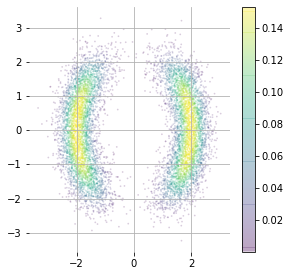

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = X_test_densities, alpha=.2,s = 3, linewidths= 0.0000001)
plt.colorbar()
plt.show()

### Fixing bandwidth

Cross Validation with 5 folds

In [ ]:
gammas = [2**i for i in range(-10,10,1)]
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
l1_error_means = []
for gamma in gammas: 
  l1_error = []
  #print(gamma) 
  # Mean of accuracy on the 5 folds wrt rawkde
  for train_index, test_index in kf.split(X_train[:,0]):
    X_train_new, X_test_new = X_train[train_index,:], X_train[test_index,:]
    X_test_real_densities = np.exp(pot_1(X_test_new).numpy())/6.529
    raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train_new , gamma = gamma) for xtest in X_test_new])    
    mae = 1 / X_test_real_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_real_densities))
    l1_error.append(mae)    
    #print(mae)
  #print('gamma:{} error:{}'.format(gamma,np.mean(l1_error)))
  l1_error_means.append(np.mean(l1_error))
print('Best gamma:{} with L1_error {}'.format(gammas[np.argmin(l1_error_means)],np.min(l1_error_means)))

Best gamma:32 with L1_error 0.006412727219440295


Fixed gamma

In [ ]:
gamma = 32

Fixed bandwidth

In [ ]:
bw = (np.sqrt(2*gamma))**(-1)

In [ ]:
bw

0.125

### Methods

#### `raw_kde`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'): 
  %time raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train , gamma = gamma) for xtest in X_test])

CPU times: user 4.42 s, sys: 7.87 ms, total: 4.43 s
Wall time: 4.43 s


Scatter plot

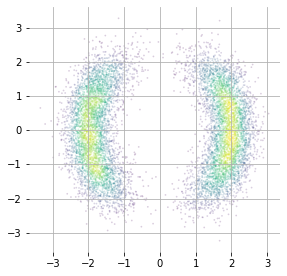

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = raw_kde_densities, alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_densities))

0.006103391601819889

#### `NaiveKDE`

Train

In [ ]:
NaiveKDE_density = NaiveKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time NaiveKDE_densities = NaiveKDE_density.evaluate(X_test)

CPU times: user 7.63 s, sys: 17.5 ms, total: 7.65 s
Wall time: 7.63 s


Scatter plot

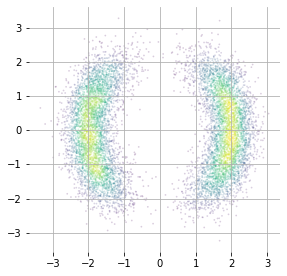

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = NaiveKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(NaiveKDE_densities - X_test_densities))

0.0061033916018198575

#### `TreeKDE`

Train

In [ ]:
TreeKDE_density = TreeKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time TreeKDE_densities = TreeKDE_density.evaluate(X_test)

CPU times: user 5.18 s, sys: 19.1 ms, total: 5.2 s
Wall time: 5.2 s


Scatter plot

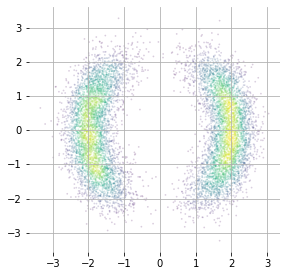

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = TreeKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(TreeKDE_densities - X_test_densities))

0.006110845327038661

#### `KernelDensity(algorithm = 'ball_tree')`

Train

In [ ]:
KernelDensitybt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'ball_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitybt_densities = np.exp(KernelDensitybt_density.score_samples(X_test))

CPU times: user 3.76 s, sys: 12.1 ms, total: 3.78 s
Wall time: 3.77 s


Scatter plot

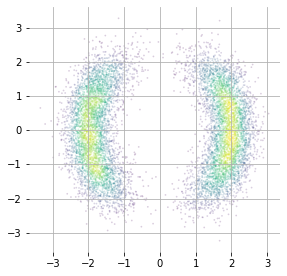

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitybt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitybt_densities - X_test_densities))

0.006103391601822349

#### `KernelDensity(algorithm = 'kd_tree')`

Train

In [ ]:
KernelDensitykdt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'kd_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitykdt_densities = np.exp(KernelDensitykdt_density.score_samples(X_test))

CPU times: user 4.13 s, sys: 10.2 ms, total: 4.14 s
Wall time: 4.14 s


Scatter plot

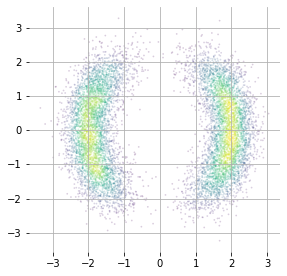

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitykdt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitykdt_densities - X_test_densities))

0.00610339160182303

#### `fastKDE`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time fastKDE_densities = fastKDE.pdf_at_points(X_train[:,0], X_train[:,1], list_of_points = X_test)

CPU times: user 15.3 s, sys: 20.1 ms, total: 15.3 s
Wall time: 15.3 s


Scatter plot

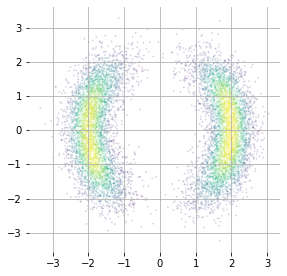

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = fastKDE_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(fastKDE_densities - X_test_densities))

0.003733789312950379

#### `DMKDE`

##### dim = 50

Train

In [ ]:
dim = 50
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_50 = models.QMDensity(fm_x, dim)
qmd_50.compile()
qmd_50.fit(X_train, epochs=1)

313/313 [==============================] - 0s 921us/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_50.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 672 ms, sys: 47.5 ms, total: 720 ms
Wall time: 599 ms


Scatter plot 

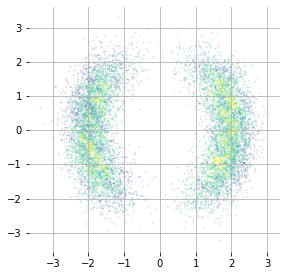

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.39271332620424393

##### dim = 100

Train

In [ ]:
dim = 100
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_100 = models.QMDensity(fm_x, dim)
qmd_100.compile()
qmd_100.fit(X_train, epochs=1)

313/313 [==============================] - 0s 902us/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_100.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 1.71 s, sys: 732 ms, total: 2.45 s
Wall time: 2 s


Scatter plot 

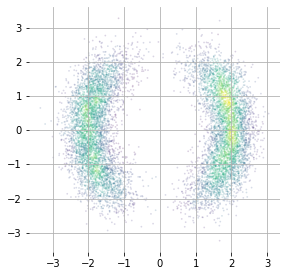

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.19799430054468284

##### dim = 500

Train

In [ ]:
dim = 500
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_500 = models.QMDensity(fm_x, dim)
qmd_500.compile()
qmd_500.fit(X_train, epochs=1)

313/313 [==============================] - 0s 989us/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_500.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 1min 38s, sys: 16.1 s, total: 1min 54s
Wall time: 1min 7s


Scatter plot 

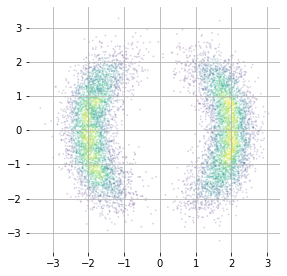

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.03375065193245554

##### dim = 1000

Train

In [ ]:
dim = 1000
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_1000 = models.QMDensity(fm_x, dim)
qmd_1000.compile()
qmd_1000.fit(X_train, epochs=1)

313/313 [==============================] - 1s 2ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_1000.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 10min 28s, sys: 9.28 s, total: 10min 37s
Wall time: 5min 31s


Scatter plot 

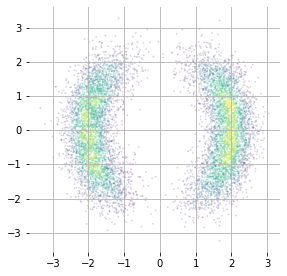

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.01443264086414578

#### `EIG-DMKDE`

##### dim = 50

Train

In [ ]:
num_eig = 50
dim = 50
sgd_model_50 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_50.set_rho(qmd_50.weights[2])

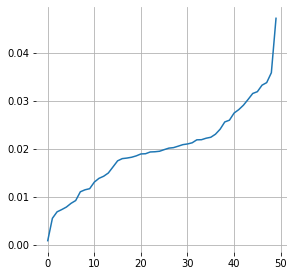

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_50.predict(X_test)

CPU times: user 499 ms, sys: 28.6 ms, total: 528 ms
Wall time: 389 ms


Scatter plot 

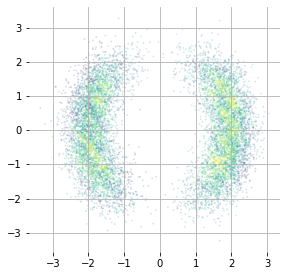

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.3927134218786395

##### dim = 100

Train

In [ ]:
num_eig = 100
dim = 100
sgd_model_100 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_100.set_rho(qmd_100.weights[2])

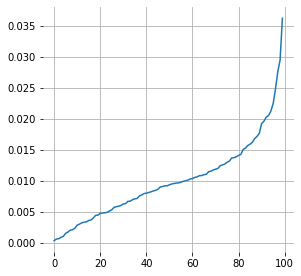

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_100.predict(X_test)

CPU times: user 511 ms, sys: 50.4 ms, total: 561 ms
Wall time: 423 ms


Scatter plot 

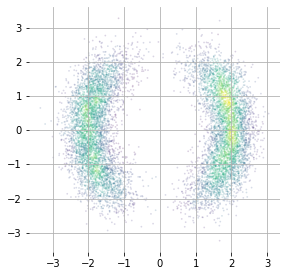

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.19799434952181943

##### dim = 500

Train

In [ ]:
num_eig = 500
dim = 500
sgd_model_500 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_500.set_rho(qmd_500.weights[2])

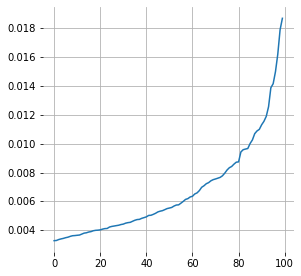

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_500.predict(X_test)

CPU times: user 3.61 s, sys: 1.22 s, total: 4.83 s
Wall time: 3.44 s


Scatter plot 

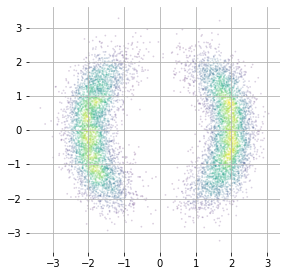

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.03375085641103232

##### dim = 1000

Train

In [ ]:
num_eig = 700
dim = 1000
sgd_model_1000 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_1000.set_rho(qmd_1000.weights[2])

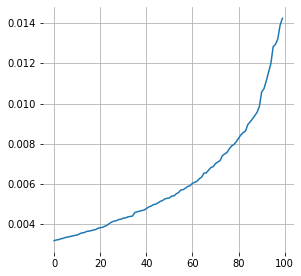

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_1000.predict(X_test)

CPU times: user 10.8 s, sys: 976 ms, total: 11.8 s
Wall time: 7.02 s


Scatter plot 

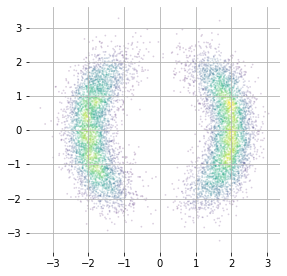

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.014433777190190577

## Experiment 5 : 100000

Split data

In [ ]:
X_train, X_test, X_train_densities, X_test_densities  = train_test_split(X, X_densities, train_size = 100000, test_size = 10000, random_state = 42)

In [ ]:
print(f'Train 2D data set shape is:{X_train.shape} and their densities shape is {X_train_densities.shape}')
print(f'Train 2D data set shape is:{X_test.shape} and their densities shape is {X_test_densities.shape}')

Train 2D data set shape is:(100000, 2) and their densities shape is (100000,)
Train 2D data set shape is:(10000, 2) and their densities shape is (10000,)


Scatter plot of test data

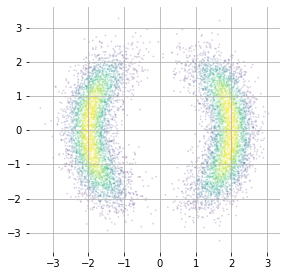

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = X_test_densities, alpha=.2,s = 3, linewidths= 0.0000001)
#plt.colorbar()
plt.savefig('testdensities_pot1.png',dpi = 300)
plt.show()

### Fixing bandwidth - Use 10.000 bandwidth

Cross Validation with 5 folds

In [ ]:
gammas = [2**i for i in range(-10,10,1)]
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
l1_error_means = []
for gamma in gammas: 
  l1_error = []
  #print(gamma) 
  # Mean of accuracy on the 5 folds wrt rawkde
  for train_index, test_index in kf.split(X_train[:,0]):
    X_train_new, X_test_new = X_train[train_index,:], X_train[test_index,:]
    X_test_real_densities = np.exp(pot_1(X_test_new).numpy())/6.529
    raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train_new , gamma = gamma) for xtest in X_test_new])    
    mae = 1 / X_test_real_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_real_densities))
    l1_error.append(mae)    
    #print(mae)
  #print('gamma:{} error:{}'.format(gamma,np.mean(l1_error)))
  l1_error_means.append(np.mean(l1_error))
print('Best gamma:{} with L1_error {}'.format(gammas[np.argmin(l1_error_means)],np.min(l1_error_means)))

Best gamma:32 with L1_error 0.006412727219440295


Fixed gamma

In [ ]:
gamma = 32

Fixed bandwidth

In [ ]:
bw = (np.sqrt(2*gamma))**(-1)

In [ ]:
bw

0.125

### Methods

#### `raw_kde`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'): 
  %time raw_kde_densities = np.array([raw_kde(xtest[np.newaxis, :], X_train , gamma = gamma) for xtest in X_test])

CPU times: user 44.6 s, sys: 548 ms, total: 45.1 s
Wall time: 45 s


Scatter plot

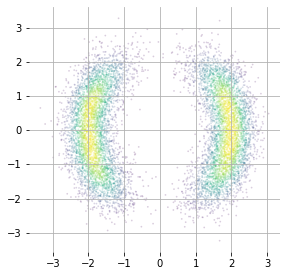

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = raw_kde_densities, alpha=.2,s = 3, linewidths= 0.0000001)
plt.savefig('testdensities_pot1_rawkde100k.png',dpi = 300)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(raw_kde_densities - X_test_densities))

0.004646067987770697

#### `NaiveKDE`

Train

In [ ]:
NaiveKDE_density = NaiveKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time NaiveKDE_densities = NaiveKDE_density.evaluate(X_test)

CPU times: user 1min 13s, sys: 156 ms, total: 1min 13s
Wall time: 1min 13s


Scatter plot

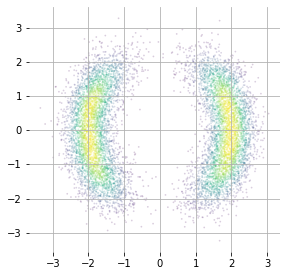

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = NaiveKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.savefig('testdensities_pot1_naivekde100k.png',dpi = 300)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(NaiveKDE_densities - X_test_densities))

0.004646067987771138

#### `TreeKDE`

Train

In [ ]:
TreeKDE_density = TreeKDE(kernel='gaussian', bw = bw).fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time TreeKDE_densities = TreeKDE_density.evaluate(X_test)

CPU times: user 22 s, sys: 52.9 ms, total: 22.1 s
Wall time: 22.1 s


Scatter plot

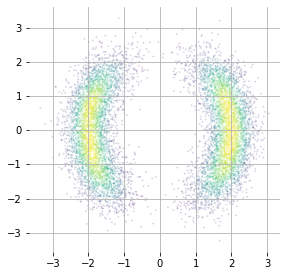

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = TreeKDE_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.savefig('testdensities_pot1_treekde100k.png',dpi = 300)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(TreeKDE_densities - X_test_densities))

0.00468153790622959

#### `KernelDensity(algorithm = 'ball_tree')`

Train

In [ ]:
KernelDensitybt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'ball_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitybt_densities = np.exp(KernelDensitybt_density.score_samples(X_test))

CPU times: user 38.3 s, sys: 143 ms, total: 38.4 s
Wall time: 38.2 s


Scatter plot

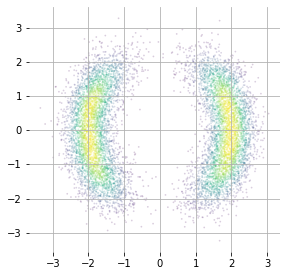

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitybt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.savefig('testdensities_pot1_kerneldensitybtkde100k.png',dpi = 300)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitybt_densities - X_test_densities))

0.004646067987834089

#### `KernelDensity(algorithm = 'kd_tree')`

Train

In [ ]:
KernelDensitykdt_density = KernelDensity(kernel='gaussian', bandwidth = bw, algorithm = 'kd_tree').fit(X_train)

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time KernelDensitykdt_densities = np.exp(KernelDensitykdt_density.score_samples(X_test))

CPU times: user 51 s, sys: 133 ms, total: 51.1 s
Wall time: 50.9 s


Scatter plot

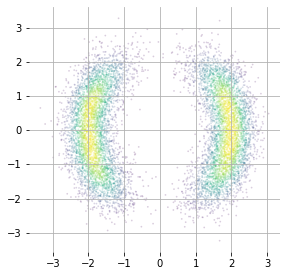

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = KernelDensitykdt_densities,alpha=.2,s = 3, linewidths= 0.0000001)
plt.savefig('testdensities_pot1_kerneldensitykdtkde100k.png',dpi = 300)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(KernelDensitykdt_densities - X_test_densities))

0.004646067987834344

#### `fastKDE`

Train and evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time fastKDE_densities = fastKDE.pdf_at_points(X_train[:,0], X_train[:,1], list_of_points = X_test)

CPU times: user 15.9 s, sys: 13.4 ms, total: 15.9 s
Wall time: 15.8 s


Scatter plot

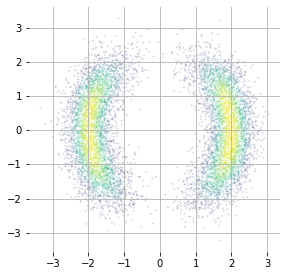

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = fastKDE_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(fastKDE_densities - X_test_densities))

0.001670767828365527

#### `DMKDE`

##### dim = 50

Train

In [ ]:
dim = 50
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_50 = models.QMDensity(fm_x, dim)
qmd_50.compile()
qmd_50.fit(X_train, epochs=1)

3125/3125 [==============================] - 2s 760us/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_50.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 667 ms, sys: 49.8 ms, total: 717 ms
Wall time: 570 ms


Scatter plot 

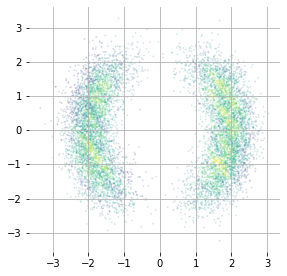

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.39265666883331896

##### dim = 100

Train

In [ ]:
dim = 100
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_100 = models.QMDensity(fm_x, dim)
qmd_100.compile()
qmd_100.fit(X_train, epochs=1)

3125/3125 [==============================] - 2s 762us/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_100.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 1.68 s, sys: 705 ms, total: 2.39 s
Wall time: 1.94 s


Scatter plot 

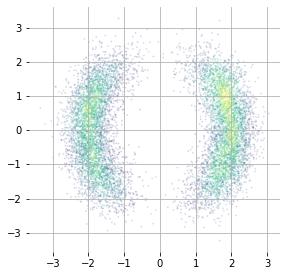

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.19803085572165618

##### dim = 500

Train

In [ ]:
dim = 500
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_500 = models.QMDensity(fm_x, dim)
qmd_500.compile()
qmd_500.fit(X_train, epochs=1)

3125/3125 [==============================] - 6s 797us/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_500.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 1min 39s, sys: 15.9 s, total: 1min 54s
Wall time: 1min 7s


Scatter plot 

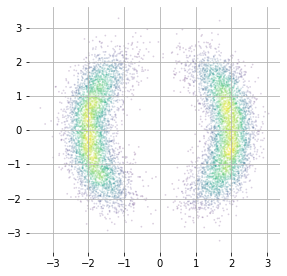

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.03347673154850669

##### dim = 1000

Train

In [ ]:
dim = 1000
fm_x = layers.QFeatureMapRFF(2, dim = dim, gamma = gamma, random_state = 18)
qmd_1000 = models.QMDensity(fm_x, dim)
qmd_1000.compile()
qmd_1000.fit(X_train, epochs=1)

3125/3125 [==============================] - 168s 54ms/step


Evaluate

In [ ]:
with tf.device('/cpu:0'):
 %time dmkde_densities = qmd_1000.predict(X_test)*calculate_constant_qmkde(gamma = gamma, dimension = 2) 

CPU times: user 10min 35s, sys: 10.1 s, total: 10min 45s
Wall time: 5min 35s


Scatter plot 

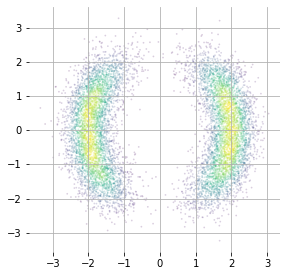

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(dmkde_densities - X_test_densities))

0.01258344019388491

#### `EIG-DMKDE`

##### dim = 50

Train

In [ ]:
num_eig = 50
dim = 50
sgd_model_50 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_50.set_rho(qmd_50.weights[2])

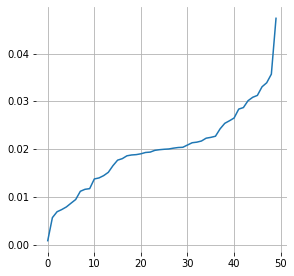

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_50.predict(X_test)

CPU times: user 492 ms, sys: 37.2 ms, total: 529 ms
Wall time: 393 ms


Scatter plot 

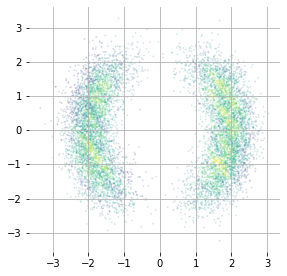

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.3926567912761605

##### dim = 100

Train

In [ ]:
num_eig = 100
dim = 100
sgd_model_100 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_100.set_rho(qmd_100.weights[2])

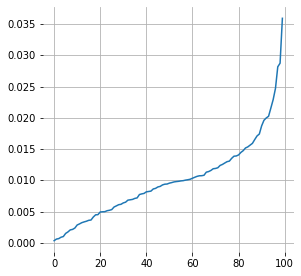

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_100.predict(X_test)

CPU times: user 561 ms, sys: 28.2 ms, total: 589 ms
Wall time: 445 ms


Scatter plot 

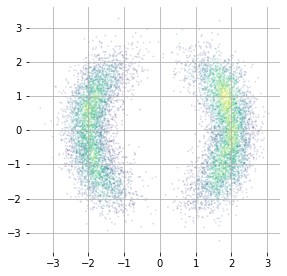

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.19803084725779663

##### dim = 500

Train

In [ ]:
num_eig = 500
dim = 500
sgd_model_500 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_500.set_rho(qmd_500.weights[2])

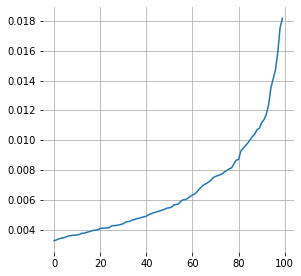

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_500.predict(X_test)

CPU times: user 3.4 s, sys: 119 ms, total: 3.52 s
Wall time: 2.17 s


Scatter plot 

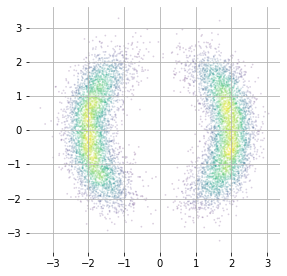

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.03347695259978242

##### dim = 1000

Train

In [ ]:
num_eig = 700
dim = 1000
sgd_model_1000 = models.QMDensitySGD(2, dim, num_eig = num_eig, gamma = gamma, random_state = 18)
eig_vals = sgd_model_1000.set_rho(qmd_1000.weights[2])

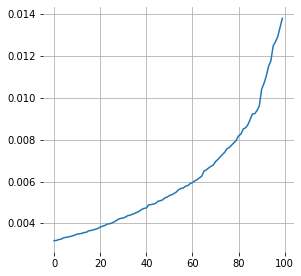

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.plot(eig_vals[-100:])
plt.show()

Evaluate

In [ ]:
with tf.device('/cpu:0'):
  %time sgd_dmkde_densities =  calculate_constant_qmkde(gamma = gamma,dimension = 2) * sgd_model_1000.predict(X_test)

CPU times: user 7.75 s, sys: 570 ms, total: 8.33 s
Wall time: 4.99 s


Scatter plot 

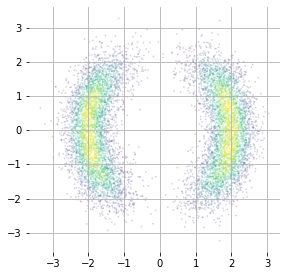

In [ ]:
plt.axes(frameon = 0)
plt.grid()
plt.scatter(X_test[:,0], X_test[:,1], c = sgd_dmkde_densities, alpha=.2, s = 3, linewidths= 0.0000001)
plt.savefig('testdensities_pot1_eigdmkde1000100k.png',dpi = 300)
plt.show()

$L_1$ error

In [ ]:
1 / X_test_densities.shape[0] * np.sum(np.abs(sgd_dmkde_densities - X_test_densities))

0.012591910041667629

## Final timing plot

In [ ]:
plt.rcParams["figure.figsize"] = (20*0.75,15*0.75)

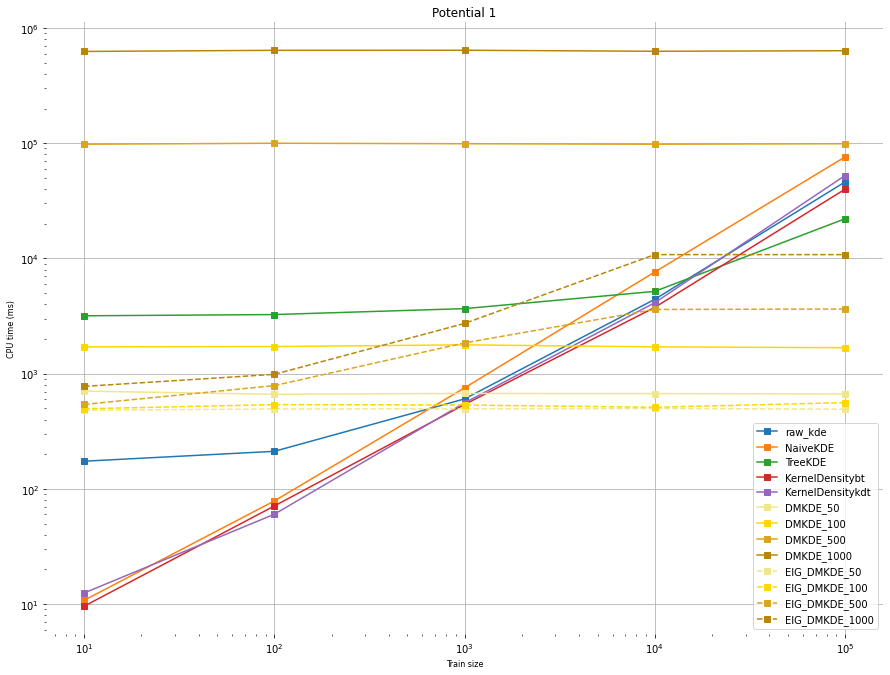

In [ ]:
train_size = [1e1,1e2,1e3,1e4,1e5]
#raw_kde
CPU_time_raw_kde = [174,212,604,4420,46100]
#NaiveKDE
CPU_time_NaiveKDE = [10.8, 78.6,753,7630,76000]
#TreeKDE
CPU_time_TreeKDE = [3180,3260,3670,5180,22100]
#KernelDensitybt
CPU_time_KernelDensitybt = [9.6,71.1,540,3760,39900]
#KernelDensitykdt
CPU_time_KernelDensitykdt = [12.5,60.3,558,4130,52400]
#fastKDE
#CPU_time_fastKDE = [3940,7780,15500,15300,15900]
#DMKDE_50
CPU_time_DMKDE_50 = [706,663,674,672,667]
#DMKDE_100
CPU_time_DMKDE_100 = [1710,1720,1780,1710,1680]
#DMKDE_500
CPU_time_DMKDE_500 = [98000,100000,99000,98000,99000]
#DMKDE_1000
CPU_time_DMKDE_1000 = [626000,640000,641000,628000,635000]
#EIG_DMKDE_50
CPU_time_EIG_DMKDE_50 = [482,494,495,499,492]
#EIG_DMKDE_100
CPU_time_EIG_DMKDE_100 = [496,539,535,511,561]
#EIG_DMKDE_500
CPU_time_EIG_DMKDE_500 = [541,788,1850,3610,3640]
#EIG_DMKDE_1000
CPU_time_EIG_DMKDE_1000 = [776,987,2730,10800,10800]
plt.axes(frameon = 0)
plt.grid()
plt.plot(train_size,CPU_time_raw_kde, c = 'tab:blue', marker = 's', label = 'raw_kde')
plt.plot(train_size,CPU_time_NaiveKDE, c = 'tab:orange' , marker = 's' , label = 'NaiveKDE')
plt.plot(train_size,CPU_time_TreeKDE, c = 'tab:green', marker = 's', label = 'TreeKDE')
plt.plot(train_size,CPU_time_KernelDensitybt, c = 'tab:red', marker = 's', label = 'KernelDensitybt')
plt.plot(train_size,CPU_time_KernelDensitykdt, c = 'tab:purple', marker = 's', label = 'KernelDensitykdt')
#plt.plot(train_size,CPU_time_fastKDE, c = 'tab:brown', marker = 's', label = 'fastKDE')
plt.plot(train_size,CPU_time_DMKDE_50, c = 'khaki', marker = 's', label = 'DMKDE_50')
plt.plot(train_size,CPU_time_DMKDE_100, c = 'gold', marker = 's', label = 'DMKDE_100')
plt.plot(train_size,CPU_time_DMKDE_500, c = 'goldenrod', marker = 's', label = 'DMKDE_500')
plt.plot(train_size,CPU_time_DMKDE_1000, c = 'darkgoldenrod', marker = 's', label = 'DMKDE_1000')
plt.plot(train_size,CPU_time_EIG_DMKDE_50, c = 'khaki', marker = 's', linestyle = '--', label = 'EIG_DMKDE_50')
plt.plot(train_size,CPU_time_EIG_DMKDE_100, c = 'gold', marker = 's', linestyle = '--',label = 'EIG_DMKDE_100')
plt.plot(train_size,CPU_time_EIG_DMKDE_500, c = 'goldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_500')
plt.plot(train_size,CPU_time_EIG_DMKDE_1000, c = 'darkgoldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_1000')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Train size')
plt.ylabel('CPU time (ms)')
plt.title('Potential 1')
plt.savefig('time_pot1.png', dpi=300)
plt.show()

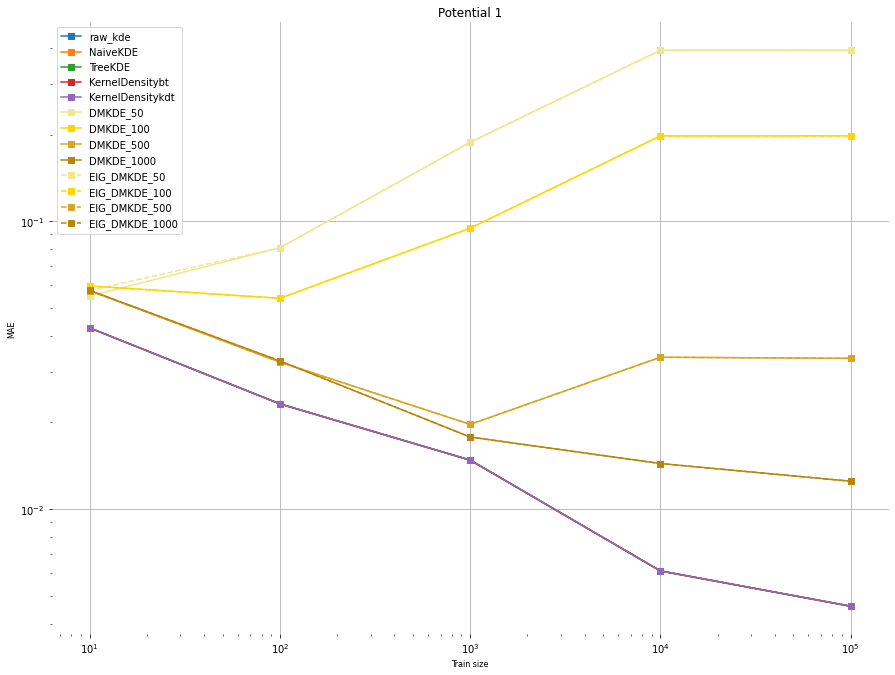

In [ ]:
train_size = [1e1,1e2,1e3,1e4,1e5]
#raw_kde
error_raw_kde = [0.0426,0.0232,0.0148,0.0061,0.0046]
#NaiveKDE
error_NaiveKDE = [0.0426,0.0232,0.0148,0.0061,0.0046]
#TreeKDE
error_TreeKDE = [0.0426,0.0232,0.0148,0.0061,0.0046]
#KernelDensitybt
error_KernelDensitybt = [0.0426,0.0232,0.0148,0.0061,0.0046]
#KernelDensitykdt
error_KernelDensitykdt = [0.0426,0.0232,0.0148,0.0061,0.0046]
#fastKDE
#error_fastKDE = [0.0727,0.0249,0.0098,0.0037,0.0016]
#DMKDE_50
error_DMKDE_50 = [0.0550,0.0809,0.1881,0.3927,0.3926]
#DMKDE_100
error_DMKDE_100 = [0.0596,0.0540,0.0946,0.1979,0.1980]
#DMKDE_500
error_DMKDE_500 = [0.0574,0.0324,0.0197,0.0337,0.0334]
#DMKDE_1000
error_DMKDE_1000 = [0.0575,0.0327,0.0178,0.0144,0.0125]
#EIG_DMKDE_50
error_EIG_DMKDE_50 = [0.0575,0.0809,0.1881,0.3927,0.3926]
#EIG_DMKDE_100
error_EIG_DMKDE_100 = [0.0596,0.0540,0.0946,0.1979,0.1980]
#EIG_DMKDE_500
error_EIG_DMKDE_500 = [0.0574,0.0324,0.0197,0.0337,0.0334]
#EIG_DMKDE_1000
error_EIG_DMKDE_1000 = [0.0575,0.0327,0.0178,0.0144,0.0125]

plt.axes(frameon = 0)
plt.grid()
plt.plot(train_size,error_raw_kde, c = 'tab:blue', marker = 's', label = 'raw_kde')
plt.plot(train_size,error_NaiveKDE, c = 'tab:orange' , marker = 's' , label = 'NaiveKDE')
plt.plot(train_size,error_TreeKDE, c = 'tab:green', marker = 's', label = 'TreeKDE')
plt.plot(train_size,error_KernelDensitybt, c = 'tab:red', marker = 's', label = 'KernelDensitybt')
plt.plot(train_size,error_KernelDensitykdt, c = 'tab:purple', marker = 's', label = 'KernelDensitykdt')
#plt.plot(train_size,error_fastKDE, c = 'tab:brown', marker = 's', label = 'fastKDE')
plt.plot(train_size,error_DMKDE_50, c = 'khaki', marker = 's', label = 'DMKDE_50')
plt.plot(train_size,error_DMKDE_100, c = 'gold', marker = 's', label = 'DMKDE_100')
plt.plot(train_size,error_DMKDE_500, c = 'goldenrod', marker = 's', label = 'DMKDE_500')
plt.plot(train_size,error_DMKDE_1000, c = 'darkgoldenrod', marker = 's', label = 'DMKDE_1000')
plt.plot(train_size,error_EIG_DMKDE_50, c = 'khaki', marker = 's', linestyle = '--', label = 'EIG_DMKDE_50')
plt.plot(train_size,error_EIG_DMKDE_100, c = 'gold', marker = 's', linestyle = '--',label = 'EIG_DMKDE_100')
plt.plot(train_size,error_EIG_DMKDE_500, c = 'goldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_500')
plt.plot(train_size,error_EIG_DMKDE_1000, c = 'darkgoldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_1000')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Train size')
plt.ylabel('MAE')
plt.title('Potential 1')
plt.savefig('mae_pot1.png', dpi=300)
plt.show()

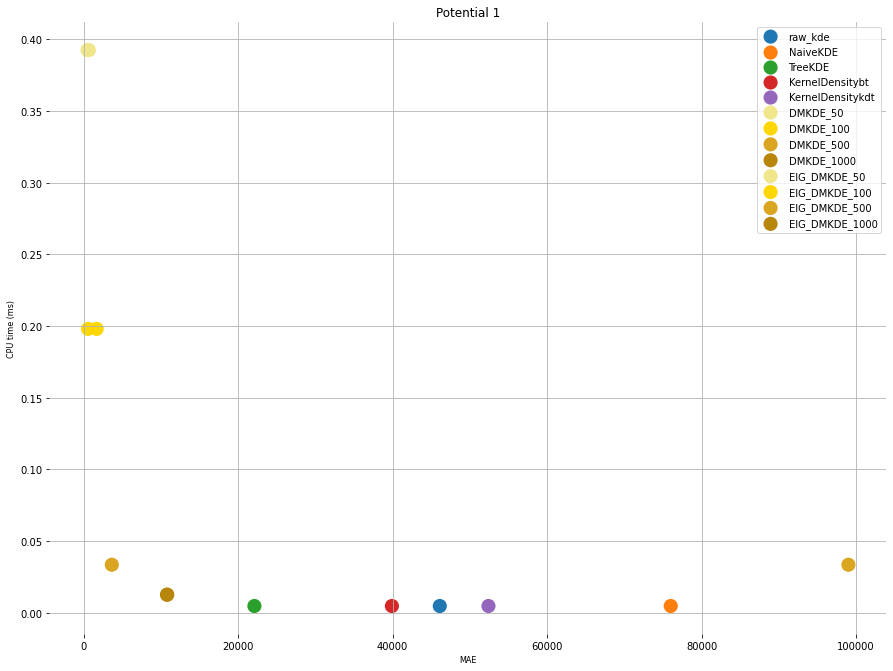

In [ ]:
#raw_kde
CPU_time_raw_kde = [174,212,604,4420,46100][4]
#NaiveKDE
CPU_time_NaiveKDE = [10.8, 78.6,753,7630,76000][4]
#TreeKDE
CPU_time_TreeKDE = [3180,3260,3670,5180,22100][4]
#KernelDensitybt
CPU_time_KernelDensitybt = [9.6,71.1,540,3760,39900][4]
#KernelDensitykdt
CPU_time_KernelDensitykdt = [12.5,60.3,558,4130,52400][4]
#fastKDE
#CPU_time_fastKDE = [3940,7780,15500,15300,15900][4]
#DMKDE_50
CPU_time_DMKDE_50 = [706,663,674,672,667][4]
#DMKDE_100
CPU_time_DMKDE_100 = [1710,1720,1780,1710,1680][4]
#DMKDE_500
CPU_time_DMKDE_500 = [98000,100000,99000,98000,99000][4]
#DMKDE_1000
CPU_time_DMKDE_1000 = [626000,640000,641000,628000,635000][4]
#EIG_DMKDE_50
CPU_time_EIG_DMKDE_50 = [482,494,495,499,492][4]
#EIG_DMKDE_100
CPU_time_EIG_DMKDE_100 = [496,539,535,511,561][4]
#EIG_DMKDE_500
CPU_time_EIG_DMKDE_500 = [541,788,1850,3610,3640][4]
#EIG_DMKDE_1000
CPU_time_EIG_DMKDE_1000 = [776,987,2730,10800,10800][4]


#raw_kde
error_raw_kde = [0.0426,0.0232,0.0148,0.0061,0.0046][4]
#NaiveKDE
error_NaiveKDE = [0.0426,0.0232,0.0148,0.0061,0.0046][4]
#TreeKDE
error_TreeKDE = [0.0426,0.0232,0.0148,0.0061,0.0046][4]
#KernelDensitybt
error_KernelDensitybt = [0.0426,0.0232,0.0148,0.0061,0.0046][4]
#KernelDensitykdt
error_KernelDensitykdt = [0.0426,0.0232,0.0148,0.0061,0.0046][4]
#fastKDE
#error_fastKDE = [0.0727,0.0249,0.0098,0.0037,0.0016][4]
#DMKDE_50
error_DMKDE_50 = [0.0550,0.0809,0.1881,0.3927,0.3926][4]
#DMKDE_100
error_DMKDE_100 = [0.0596,0.0540,0.0946,0.1979,0.1980][4]
#DMKDE_500
error_DMKDE_500 = [0.0574,0.0324,0.0197,0.0337,0.0334][4]
#DMKDE_1000
error_DMKDE_1000 = [0.0575,0.0327,0.0178,0.0144,0.0125][4]
#EIG_DMKDE_50
error_EIG_DMKDE_50 = [0.0575,0.0809,0.1881,0.3927,0.3926][4]
#EIG_DMKDE_100
error_EIG_DMKDE_100 = [0.0596,0.0540,0.0946,0.1979,0.1980][4]
#EIG_DMKDE_500
error_EIG_DMKDE_500 = [0.0574,0.0324,0.0197,0.0337,0.0334][4]
#EIG_DMKDE_1000
error_EIG_DMKDE_1000 = [0.0575,0.0327,0.0178,0.0144,0.0125][4]

scatter_100m = np.array([[CPU_time_raw_kde,error_raw_kde],
                [CPU_time_NaiveKDE,error_NaiveKDE],
                [CPU_time_TreeKDE,error_TreeKDE],
                [CPU_time_KernelDensitybt,error_KernelDensitybt],
                [CPU_time_KernelDensitykdt,error_KernelDensitykdt],
                [CPU_time_DMKDE_50,error_DMKDE_50],
                [CPU_time_DMKDE_100,error_DMKDE_100],
                [CPU_time_DMKDE_500,error_DMKDE_500],
                [CPU_time_EIG_DMKDE_1000,error_DMKDE_1000],
                [CPU_time_EIG_DMKDE_50,error_DMKDE_50],
                [CPU_time_EIG_DMKDE_100,error_DMKDE_100],
                [CPU_time_EIG_DMKDE_500,error_DMKDE_500],
                [CPU_time_EIG_DMKDE_1000,error_DMKDE_1000]
                ]).T

labels = ['raw_kde','NaiveKDE','TreeKDE','KernelDensitybt','KernelDensitykdt','DMKDE_50','DMKDE_100','DMKDE_500','DMKDE_1000','EIG_DMKDE_50','EIG_DMKDE_100'
,'EIG_DMKDE_500','EIG_DMKDE_1000']

colors = np.array(['tab:blue','tab:orange','tab:green','tab:red','tab:purple','khaki','gold','goldenrod','darkgoldenrod','khaki','gold','goldenrod','darkgoldenrod'])

#
fig, ax = plt.subplots()
j=0
for color,label in zip(colors,labels):
    x, y = (scatter_100m[0][j],scatter_100m[1][j])
    ax.grid(True)
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.scatter(x, y, c= color, label= label,s = 200, edgecolors='none')
    j+=1
ax.set_xlabel('CPU time (ms)')
ax.set_ylabel('MAE')
ax.set_title('Potential 1')
ax.grid(b=True)
ax.legend(loc = 1)
fig.savefig('eff_pot1.png', dpi=300)

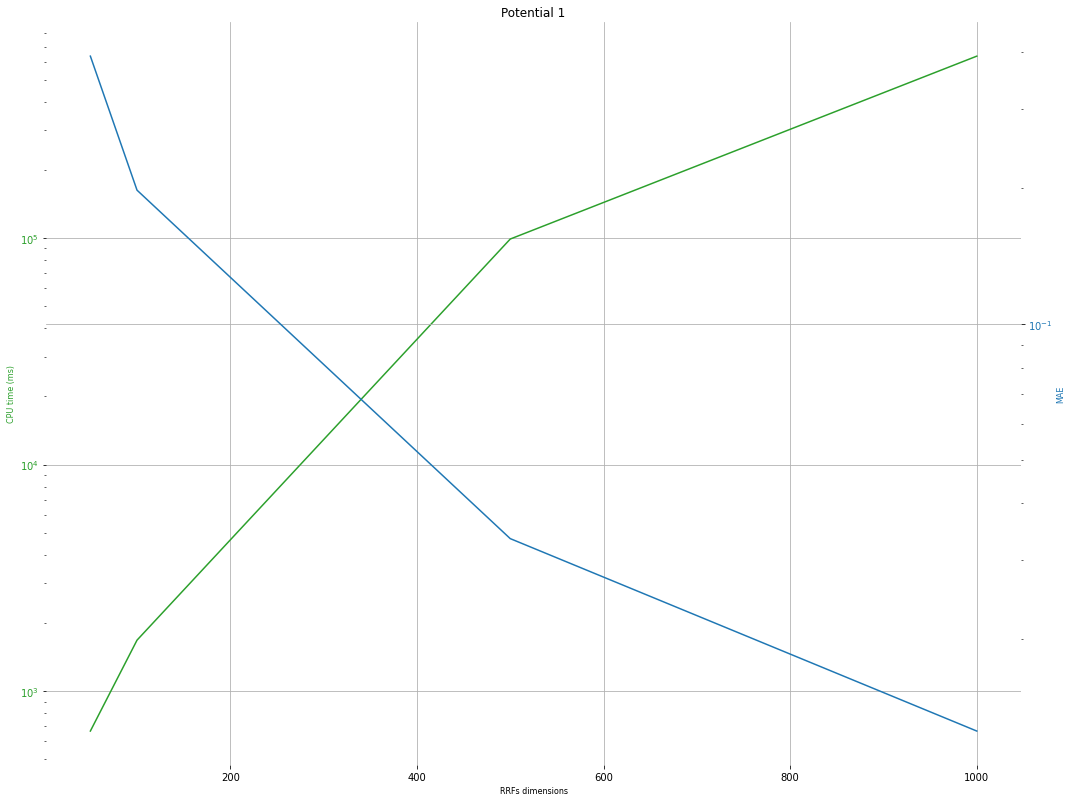

In [ ]:
#EIG_DMKDE_50
CPU_time_EIG_DMKDE_50 = [482,494,495,499,492][4]
#EIG_DMKDE_100
CPU_time_EIG_DMKDE_100 = [496,539,535,511,561][4]
#EIG_DMKDE_500
CPU_time_EIG_DMKDE_500 = [541,788,1850,3610,3640][4]
#EIG_DMKDE_1000
CPU_time_EIG_DMKDE_1000 = [776,987,2730,10800,10800][4]

#EIG_DMKDE_50
error_EIG_DMKDE_50 = [0.0575,0.0809,0.1881,0.3927,0.3926][4]
#EIG_DMKDE_100
error_EIG_DMKDE_100 = [0.0596,0.0540,0.0946,0.1979,0.1980][4]
#EIG_DMKDE_500
error_EIG_DMKDE_500 = [0.0574,0.0324,0.0197,0.0337,0.0334][4]
#EIG_DMKDE_1000
error_EIG_DMKDE_1000 = [0.0575,0.0327,0.0178,0.0144,0.0125][4]
t = [50.,100.,500.,1000.]
data1 = [CPU_time_DMKDE_50,CPU_time_DMKDE_100,CPU_time_DMKDE_500,CPU_time_DMKDE_1000]
data2 = [error_EIG_DMKDE_50,error_EIG_DMKDE_100,error_EIG_DMKDE_500,error_EIG_DMKDE_1000]

fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_title('Potential 1')
ax1.grid(True)
ax1.spines["bottom"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.set_xlabel('RRFs dimensions')
ax1.set_ylabel('CPU time (ms)', color=color)
ax1.set_yscale('log')
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.grid(True)
ax2.spines["bottom"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.set_ylabel('MAE', color=color)  # we already handled the x-label with ax1
ax2.set_yscale('log')
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig('rff_pot1.png', dpi=300)
plt.show()

## Final timing plot

In [10]:
!pip install SciencePlots

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for SciencePlots: filename=SciencePlots-1.0.9-py3-none-any.whl size=6484 sha256=5c6acb8eb371b60eb6ca1f2e8d695e0ce600cd7c4146794df3b80b24ba930e4b
  Stored in directory: /root/.cache/pip/wheels/37/f8/e9/b2f53a40b336388dfc57b108150daff7d6ffbbfc618dba3924
Successfully built SciencePlots


In [11]:
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super
!pip install latex

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre ghostscript gsfonts javascript-common
  libcupsfilters1 libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpotrace0 libptexenc1 libruby2.5 libsynctex1
  libtexlua52 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-recommended
  texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto ghostscript-x apach

In [12]:
plt.style.reload_library()
plt.style.use(['science','ieee','no-latex'])

In [13]:
size = (5,4)

In [14]:
plt.rcParams["figure.figsize"] = size

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


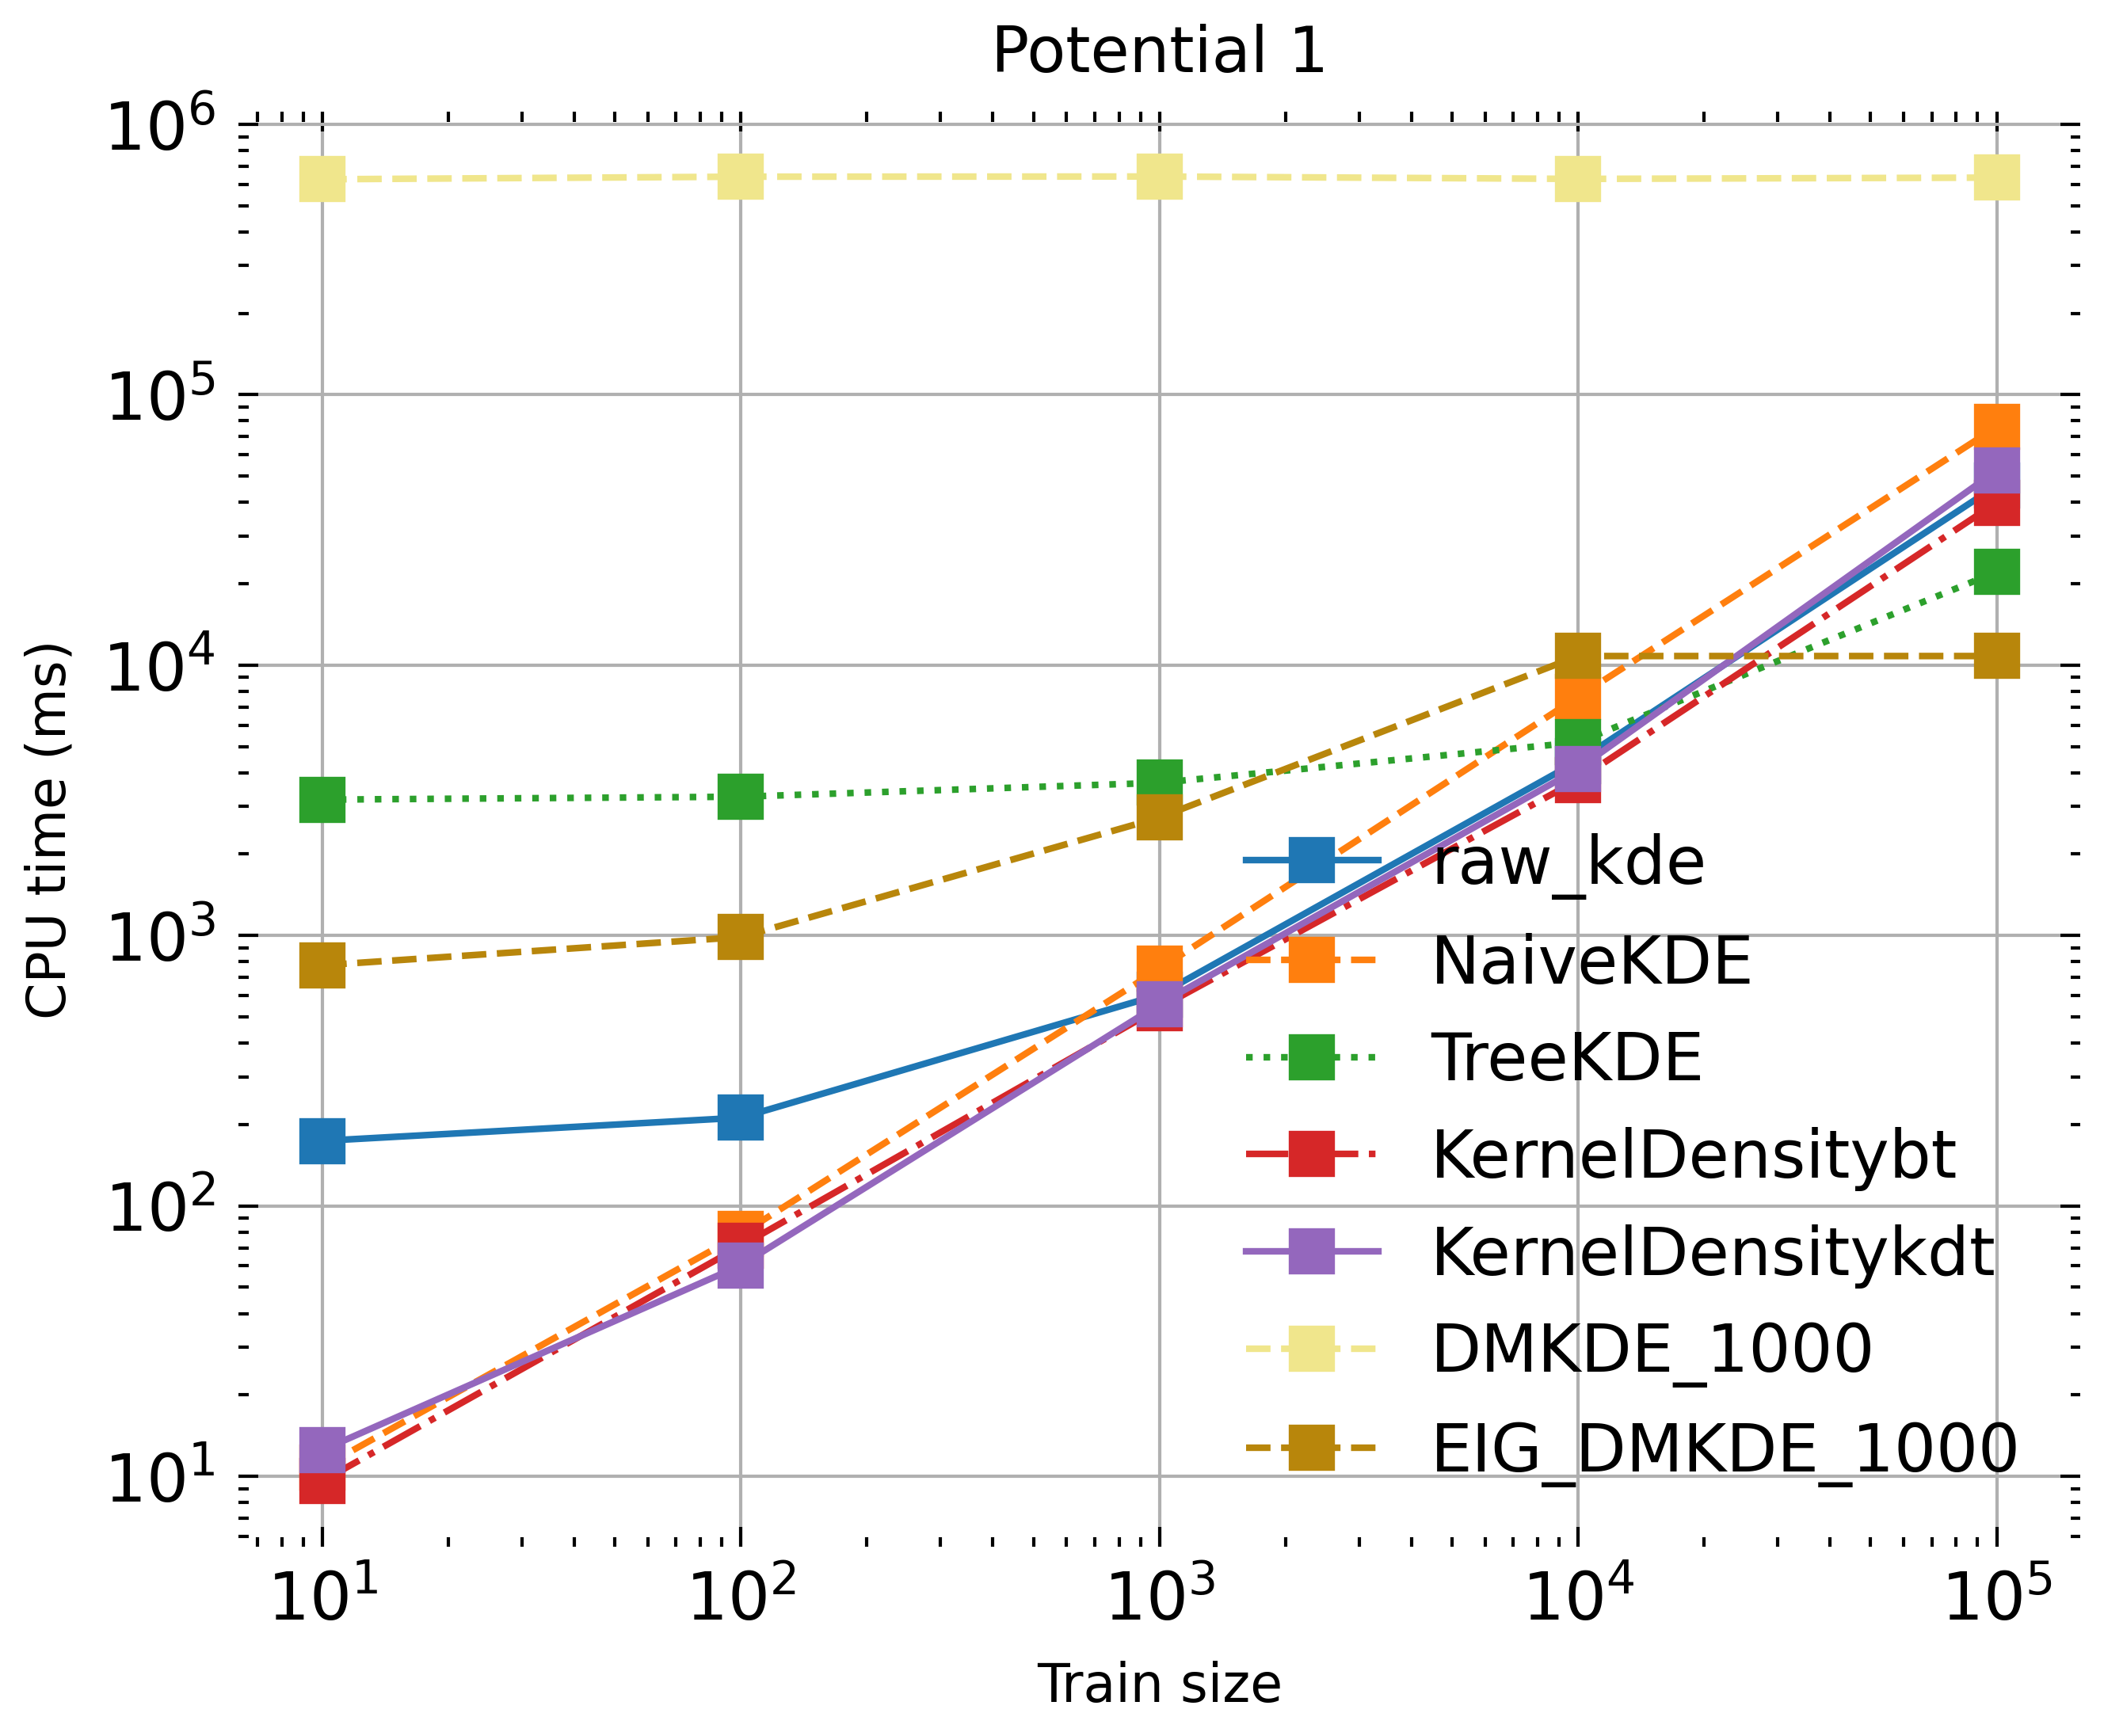

In [15]:
train_size = [1e1,1e2,1e3,1e4,1e5]
#raw_kde
CPU_time_raw_kde = [174,212,604,4420,46100]
#NaiveKDE
CPU_time_NaiveKDE = [10.8, 78.6,753,7630,76000]
#TreeKDE
CPU_time_TreeKDE = [3180,3260,3670,5180,22100]
#KernelDensitybt
CPU_time_KernelDensitybt = [9.6,71.1,540,3760,39900]
#KernelDensitykdt
CPU_time_KernelDensitykdt = [12.5,60.3,558,4130,52400]
#fastKDE
#CPU_time_fastKDE = [3940,7780,15500,15300,15900]
#DMKDE_50
CPU_time_DMKDE_50 = [706,663,674,672,667]
#DMKDE_100
CPU_time_DMKDE_100 = [1710,1720,1780,1710,1680]
#DMKDE_500
CPU_time_DMKDE_500 = [98000,100000,99000,98000,99000]
#DMKDE_1000
CPU_time_DMKDE_1000 = [626000,640000,641000,628000,635000]
#EIG_DMKDE_50
CPU_time_EIG_DMKDE_50 = [482,494,495,499,492]
#EIG_DMKDE_100
CPU_time_EIG_DMKDE_100 = [496,539,535,511,561]
#EIG_DMKDE_500
CPU_time_EIG_DMKDE_500 = [541,788,1850,3610,3640]
#EIG_DMKDE_1000
CPU_time_EIG_DMKDE_1000 = [776,987,2730,10800,10800]
plt.axes(frameon = 0)
plt.grid()
plt.plot(train_size,CPU_time_raw_kde, c = 'tab:blue', marker = 's', label = 'raw_kde')
plt.plot(train_size,CPU_time_NaiveKDE, c = 'tab:orange' , marker = 's' , label = 'NaiveKDE')
plt.plot(train_size,CPU_time_TreeKDE, c = 'tab:green', marker = 's', label = 'TreeKDE')
plt.plot(train_size,CPU_time_KernelDensitybt, c = 'tab:red', marker = 's', label = 'KernelDensitybt')
plt.plot(train_size,CPU_time_KernelDensitykdt, c = 'tab:purple', marker = 's', label = 'KernelDensitykdt')
#plt.plot(train_size,CPU_time_fastKDE, c = 'tab:brown', marker = 's', label = 'fastKDE')
#plt.plot(train_size,CPU_time_DMKDE_50, c = 'khaki', marker = 's', label = 'DMKDE_50')
#plt.plot(train_size,CPU_time_DMKDE_100, c = 'gold', marker = 's', label = 'DMKDE_100')
#plt.plot(train_size,CPU_time_DMKDE_500, c = 'goldenrod', marker = 's', label = 'DMKDE_500')
plt.plot(train_size,CPU_time_DMKDE_1000, c = 'khaki', marker = 's', label = 'DMKDE_1000')
#plt.plot(train_size,CPU_time_EIG_DMKDE_50, c = 'khaki', marker = 's', linestyle = '--', label = 'EIG_DMKDE_50')
#plt.plot(train_size,CPU_time_EIG_DMKDE_100, c = 'gold', marker = 's', linestyle = '--',label = 'EIG_DMKDE_100')
#plt.plot(train_size,CPU_time_EIG_DMKDE_500, c = 'goldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_500')
plt.plot(train_size,CPU_time_EIG_DMKDE_1000, c = 'darkgoldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_1000')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Train size')
plt.ylabel('CPU time (ms)')
plt.title('Potential 1')
plt.savefig('time_pot1.png', dpi=300)
plt.show()

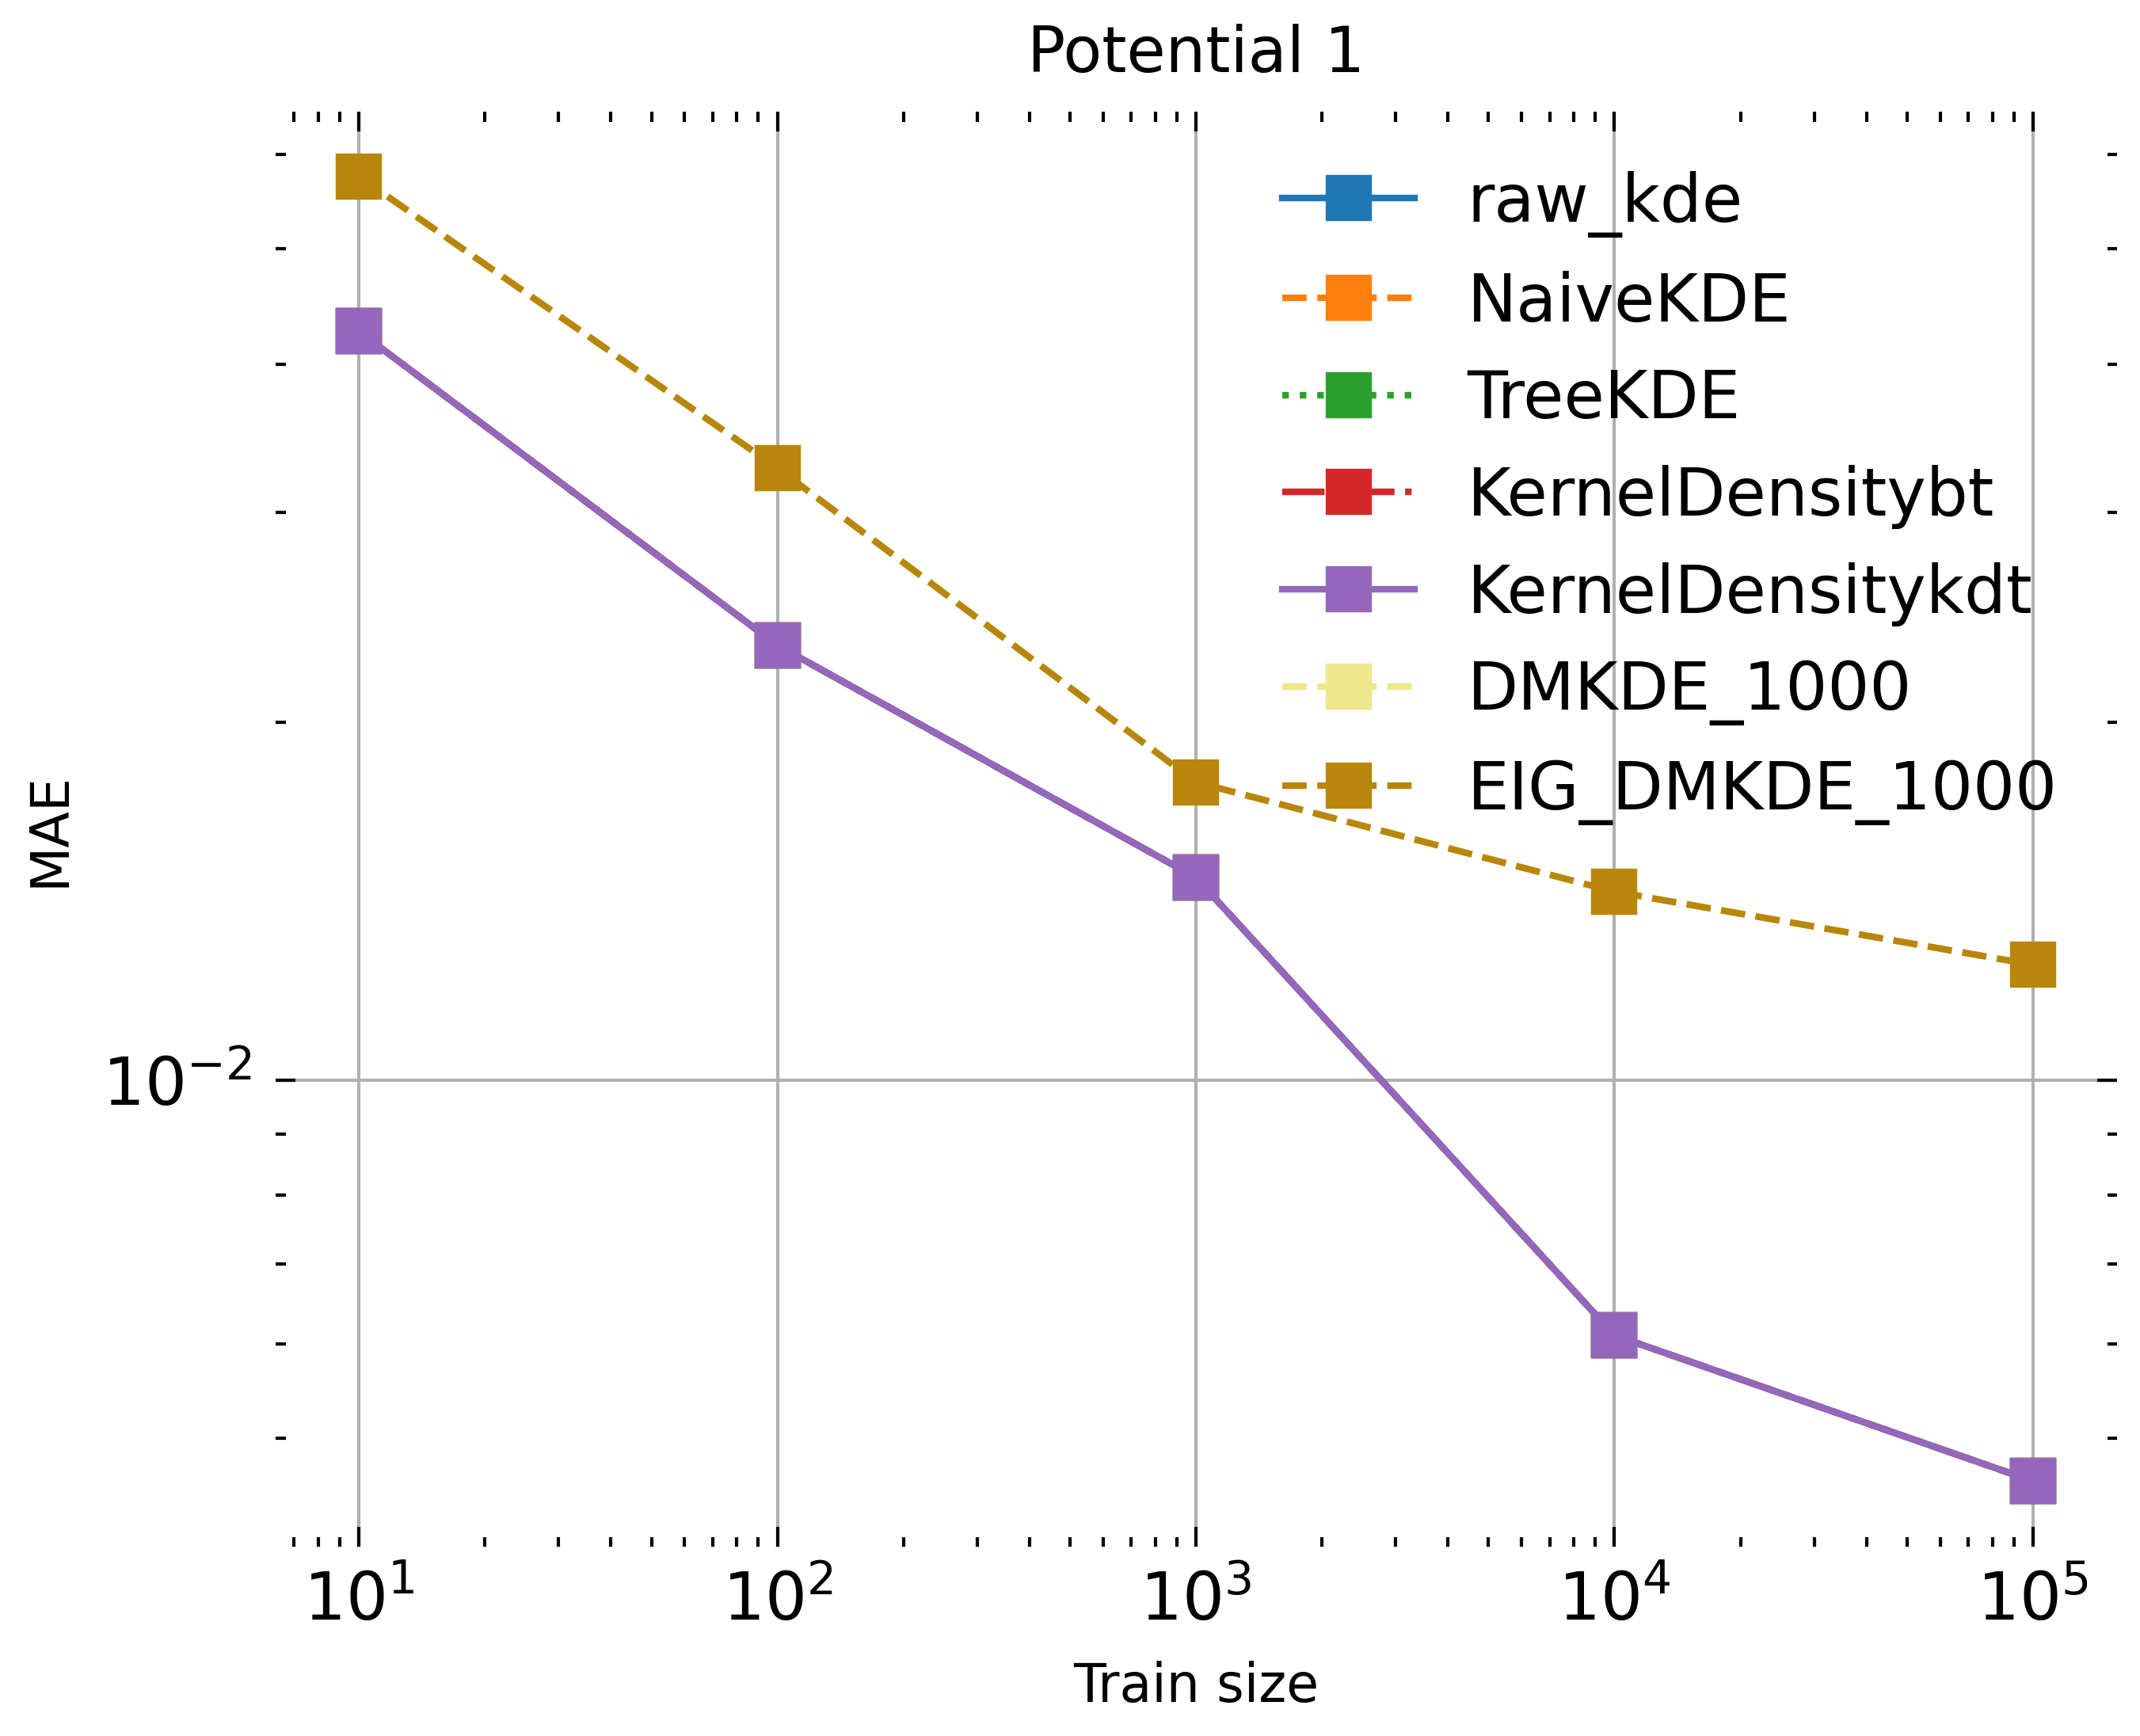

In [16]:
train_size = [1e1,1e2,1e3,1e4,1e5]
#raw_kde
error_raw_kde = [0.0426,0.0232,0.0148,0.0061,0.0046]
#NaiveKDE
error_NaiveKDE = [0.0426,0.0232,0.0148,0.0061,0.0046]
#TreeKDE
error_TreeKDE = [0.0426,0.0232,0.0148,0.0061,0.0046]
#KernelDensitybt
error_KernelDensitybt = [0.0426,0.0232,0.0148,0.0061,0.0046]
#KernelDensitykdt
error_KernelDensitykdt = [0.0426,0.0232,0.0148,0.0061,0.0046]
#fastKDE
#error_fastKDE = [0.0727,0.0249,0.0098,0.0037,0.0016]
#DMKDE_50
error_DMKDE_50 = [0.0550,0.0809,0.1881,0.3927,0.3926]
#DMKDE_100
error_DMKDE_100 = [0.0596,0.0540,0.0946,0.1979,0.1980]
#DMKDE_500
error_DMKDE_500 = [0.0574,0.0324,0.0197,0.0337,0.0334]
#DMKDE_1000
error_DMKDE_1000 = [0.0575,0.0327,0.0178,0.0144,0.0125]
#EIG_DMKDE_50
error_EIG_DMKDE_50 = [0.0575,0.0809,0.1881,0.3927,0.3926]
#EIG_DMKDE_100
error_EIG_DMKDE_100 = [0.0596,0.0540,0.0946,0.1979,0.1980]
#EIG_DMKDE_500
error_EIG_DMKDE_500 = [0.0574,0.0324,0.0197,0.0337,0.0334]
#EIG_DMKDE_1000
error_EIG_DMKDE_1000 = [0.0575,0.0327,0.0178,0.0144,0.0125]

plt.axes(frameon = 0)
plt.grid()
plt.plot(train_size,error_raw_kde, c = 'tab:blue', marker = 's', label = 'raw_kde')
plt.plot(train_size,error_NaiveKDE, c = 'tab:orange' , marker = 's' , label = 'NaiveKDE')
plt.plot(train_size,error_TreeKDE, c = 'tab:green', marker = 's', label = 'TreeKDE')
plt.plot(train_size,error_KernelDensitybt, c = 'tab:red', marker = 's', label = 'KernelDensitybt')
plt.plot(train_size,error_KernelDensitykdt, c = 'tab:purple', marker = 's', label = 'KernelDensitykdt')
#plt.plot(train_size,error_fastKDE, c = 'tab:brown', marker = 's', label = 'fastKDE')
#plt.plot(train_size,error_DMKDE_50, c = 'khaki', marker = 's', label = 'DMKDE_50')
#plt.plot(train_size,error_DMKDE_100, c = 'gold', marker = 's', label = 'DMKDE_100')
#plt.plot(train_size,error_DMKDE_500, c = 'goldenrod', marker = 's', label = 'DMKDE_500')
plt.plot(train_size,error_DMKDE_1000, c = 'khaki', marker = 's', label = 'DMKDE_1000')
#plt.plot(train_size,error_EIG_DMKDE_50, c = 'khaki', marker = 's', linestyle = '--', label = 'EIG_DMKDE_50')
#plt.plot(train_size,error_EIG_DMKDE_100, c = 'gold', marker = 's', linestyle = '--',label = 'EIG_DMKDE_100')
#plt.plot(train_size,error_EIG_DMKDE_500, c = 'goldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_500')
plt.plot(train_size,error_EIG_DMKDE_1000, c = 'darkgoldenrod', marker = 's', linestyle = '--', label = 'EIG_DMKDE_1000')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Train size')
plt.ylabel('MAE')
plt.title('Potential 1')
plt.savefig('mae_pot1.png', dpi=300)
plt.show()

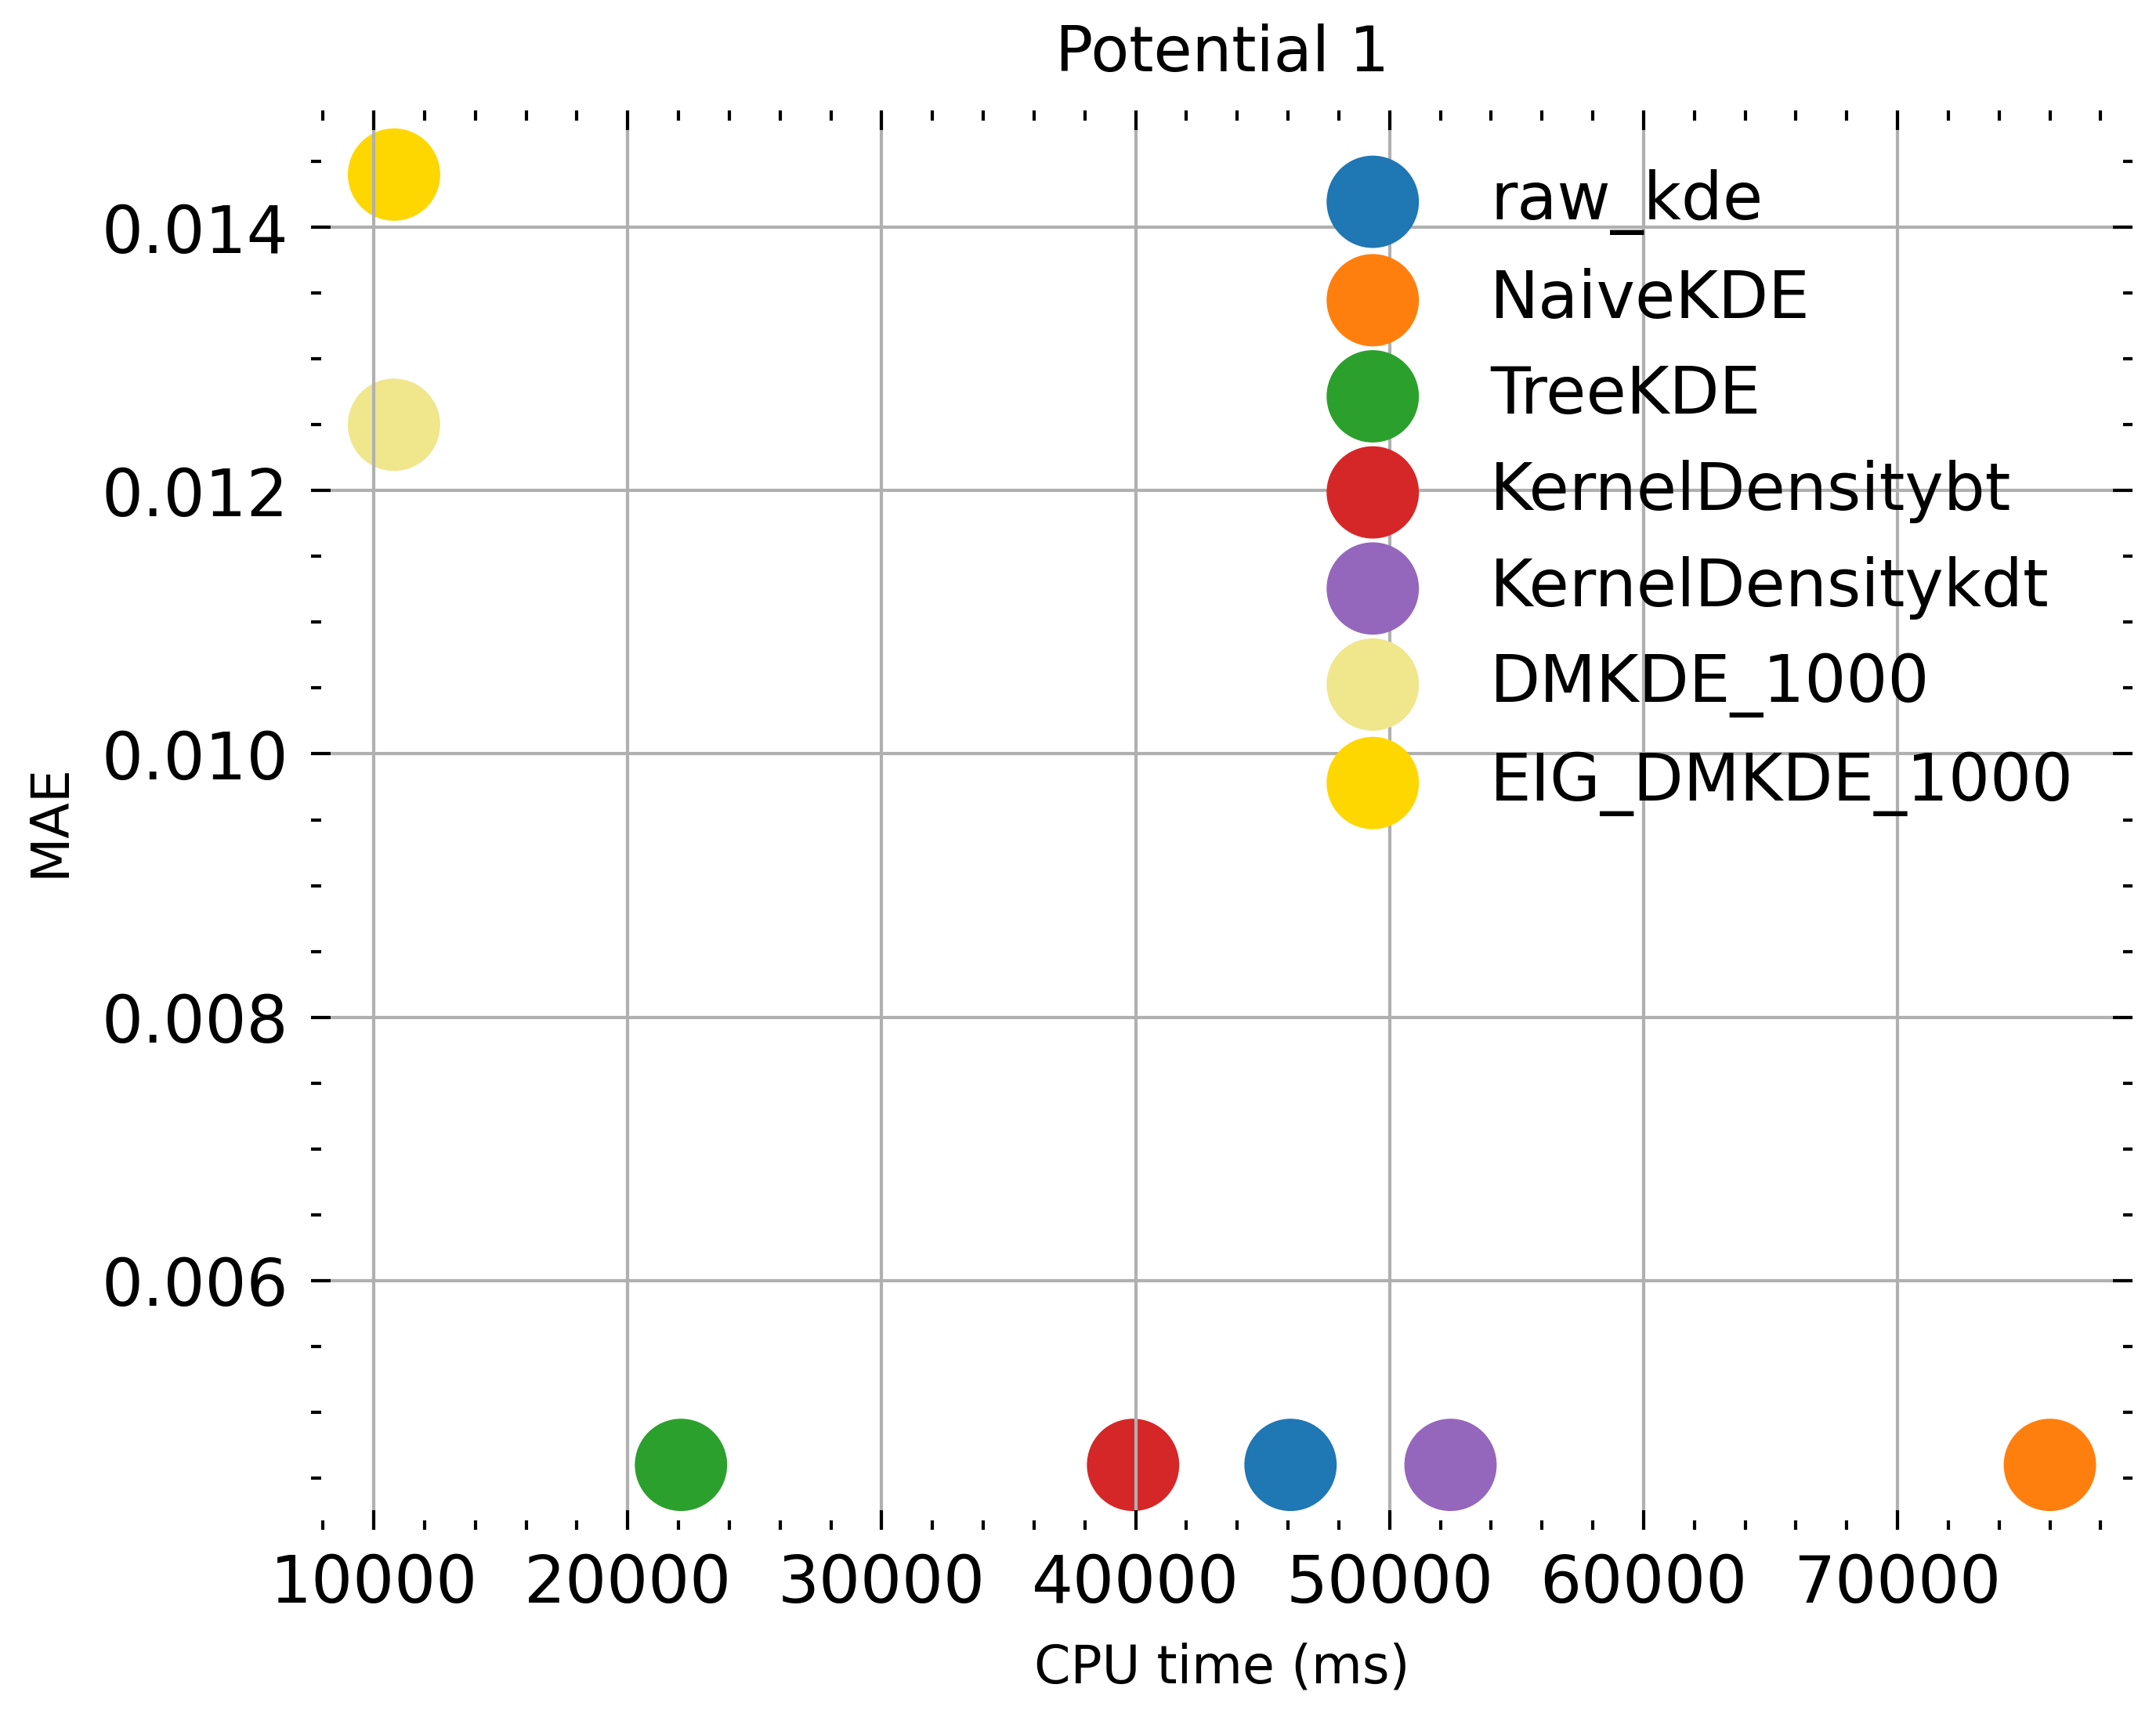

In [17]:
#raw_kde
CPU_time_raw_kde = [174,212,604,4420,46100][4]
#NaiveKDE
CPU_time_NaiveKDE = [10.8, 78.6,753,7630,76000][4]
#TreeKDE
CPU_time_TreeKDE = [3180,3260,3670,5180,22100][4]
#KernelDensitybt
CPU_time_KernelDensitybt = [9.6,71.1,540,3760,39900][4]
#KernelDensitykdt
CPU_time_KernelDensitykdt = [12.5,60.3,558,4130,52400][4]
#fastKDE
#CPU_time_fastKDE = [3940,7780,15500,15300,15900][4]
#DMKDE_50
CPU_time_DMKDE_50 = [706,663,674,672,667][4]
#DMKDE_100
CPU_time_DMKDE_100 = [1710,1720,1780,1710,1680][4]
#DMKDE_500
CPU_time_DMKDE_500 = [98000,100000,99000,98000,99000][4]
#DMKDE_1000
CPU_time_DMKDE_1000 = [626000,640000,641000,628000,635000][4]
#EIG_DMKDE_50
CPU_time_EIG_DMKDE_50 = [482,494,495,499,492][4]
#EIG_DMKDE_100
CPU_time_EIG_DMKDE_100 = [496,539,535,511,561][4]
#EIG_DMKDE_500
CPU_time_EIG_DMKDE_500 = [541,788,1850,3610,3640][4]
#EIG_DMKDE_1000
CPU_time_EIG_DMKDE_1000 = [776,987,2730,10800,10800][4]


#raw_kde
error_raw_kde = [0.0426,0.0232,0.0148,0.0061,0.0046][4]
#NaiveKDE
error_NaiveKDE = [0.0426,0.0232,0.0148,0.0061,0.0046][4]
#TreeKDE
error_TreeKDE = [0.0426,0.0232,0.0148,0.0061,0.0046][4]
#KernelDensitybt
error_KernelDensitybt = [0.0426,0.0232,0.0148,0.0061,0.0046][4]
#KernelDensitykdt
error_KernelDensitykdt = [0.0426,0.0232,0.0148,0.0061,0.0046][4]
#fastKDE
#error_fastKDE = [0.0727,0.0249,0.0098,0.0037,0.0016][4]
#DMKDE_50
error_DMKDE_50 = [0.0550,0.0809,0.1881,0.3927,0.3926][4]
#DMKDE_100
error_DMKDE_100 = [0.0596,0.0540,0.0946,0.1979,0.1980][4]
#DMKDE_500
error_DMKDE_500 = [0.0574,0.0324,0.0197,0.0337,0.0334][4]
#DMKDE_1000
error_DMKDE_1000 = [0.0575,0.0327,0.0178,0.0144,0.0125][4]
#EIG_DMKDE_50
error_EIG_DMKDE_50 = [0.0575,0.0809,0.1881,0.3927,0.3926][4]
#EIG_DMKDE_100
error_EIG_DMKDE_100 = [0.0596,0.0540,0.0946,0.1979,0.1980][4]
#EIG_DMKDE_500
error_EIG_DMKDE_500 = [0.0574,0.0324,0.0197,0.0337,0.0334][4]
#EIG_DMKDE_1000
error_EIG_DMKDE_1000 = [0.0575,0.0327,0.0178,0.0144,0.0125][3]

scatter_100m ={"raw_kde": [CPU_time_raw_kde,error_raw_kde],
                'NaiveKDE':[CPU_time_NaiveKDE,error_NaiveKDE],
                'TreeKDE':[CPU_time_TreeKDE,error_TreeKDE],
                'KernelDensitybt':[CPU_time_KernelDensitybt,error_KernelDensitybt],
                'KernelDensitykdt':[CPU_time_KernelDensitykdt,error_KernelDensitykdt],
                'DMKDE_50':[CPU_time_DMKDE_50,error_DMKDE_50],
                'DMKDE_100':[CPU_time_DMKDE_100,error_DMKDE_100],
                'DMKDE_500':[CPU_time_DMKDE_500,error_DMKDE_500],
                'DMKDE_1000':[CPU_time_EIG_DMKDE_1000,error_DMKDE_1000],
                'EIG_DMKDE_50':[CPU_time_EIG_DMKDE_50,error_EIG_DMKDE_50],
                'EIG_DMKDE_100':[CPU_time_EIG_DMKDE_100,error_EIG_DMKDE_100],
                'EIG_DMKDE_500':[CPU_time_EIG_DMKDE_500,error_EIG_DMKDE_500],
                'EIG_DMKDE_1000':[CPU_time_EIG_DMKDE_1000,error_EIG_DMKDE_1000]
          }

labels = ['raw_kde','NaiveKDE','TreeKDE','KernelDensitybt','KernelDensitykdt','DMKDE_1000', 'EIG_DMKDE_1000']

colors = np.array(['tab:blue','tab:orange','tab:green','tab:red','tab:purple','khaki','gold','darkgoldenrod'])
#
fig, ax = plt.subplots()
for color,label in zip(colors,labels):
    x, y = (scatter_100m[label][0],scatter_100m[label][1])
    ax.grid(True)
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.scatter(x, y, c= color, label= label,s = 200, edgecolors='none')
ax.set_xlabel('CPU time (ms)')
ax.set_ylabel('MAE')
ax.set_title('Potential 1')
ax.grid(b=True)
ax.legend(loc = 1)
fig.savefig('eff_pot1.png', dpi=300)

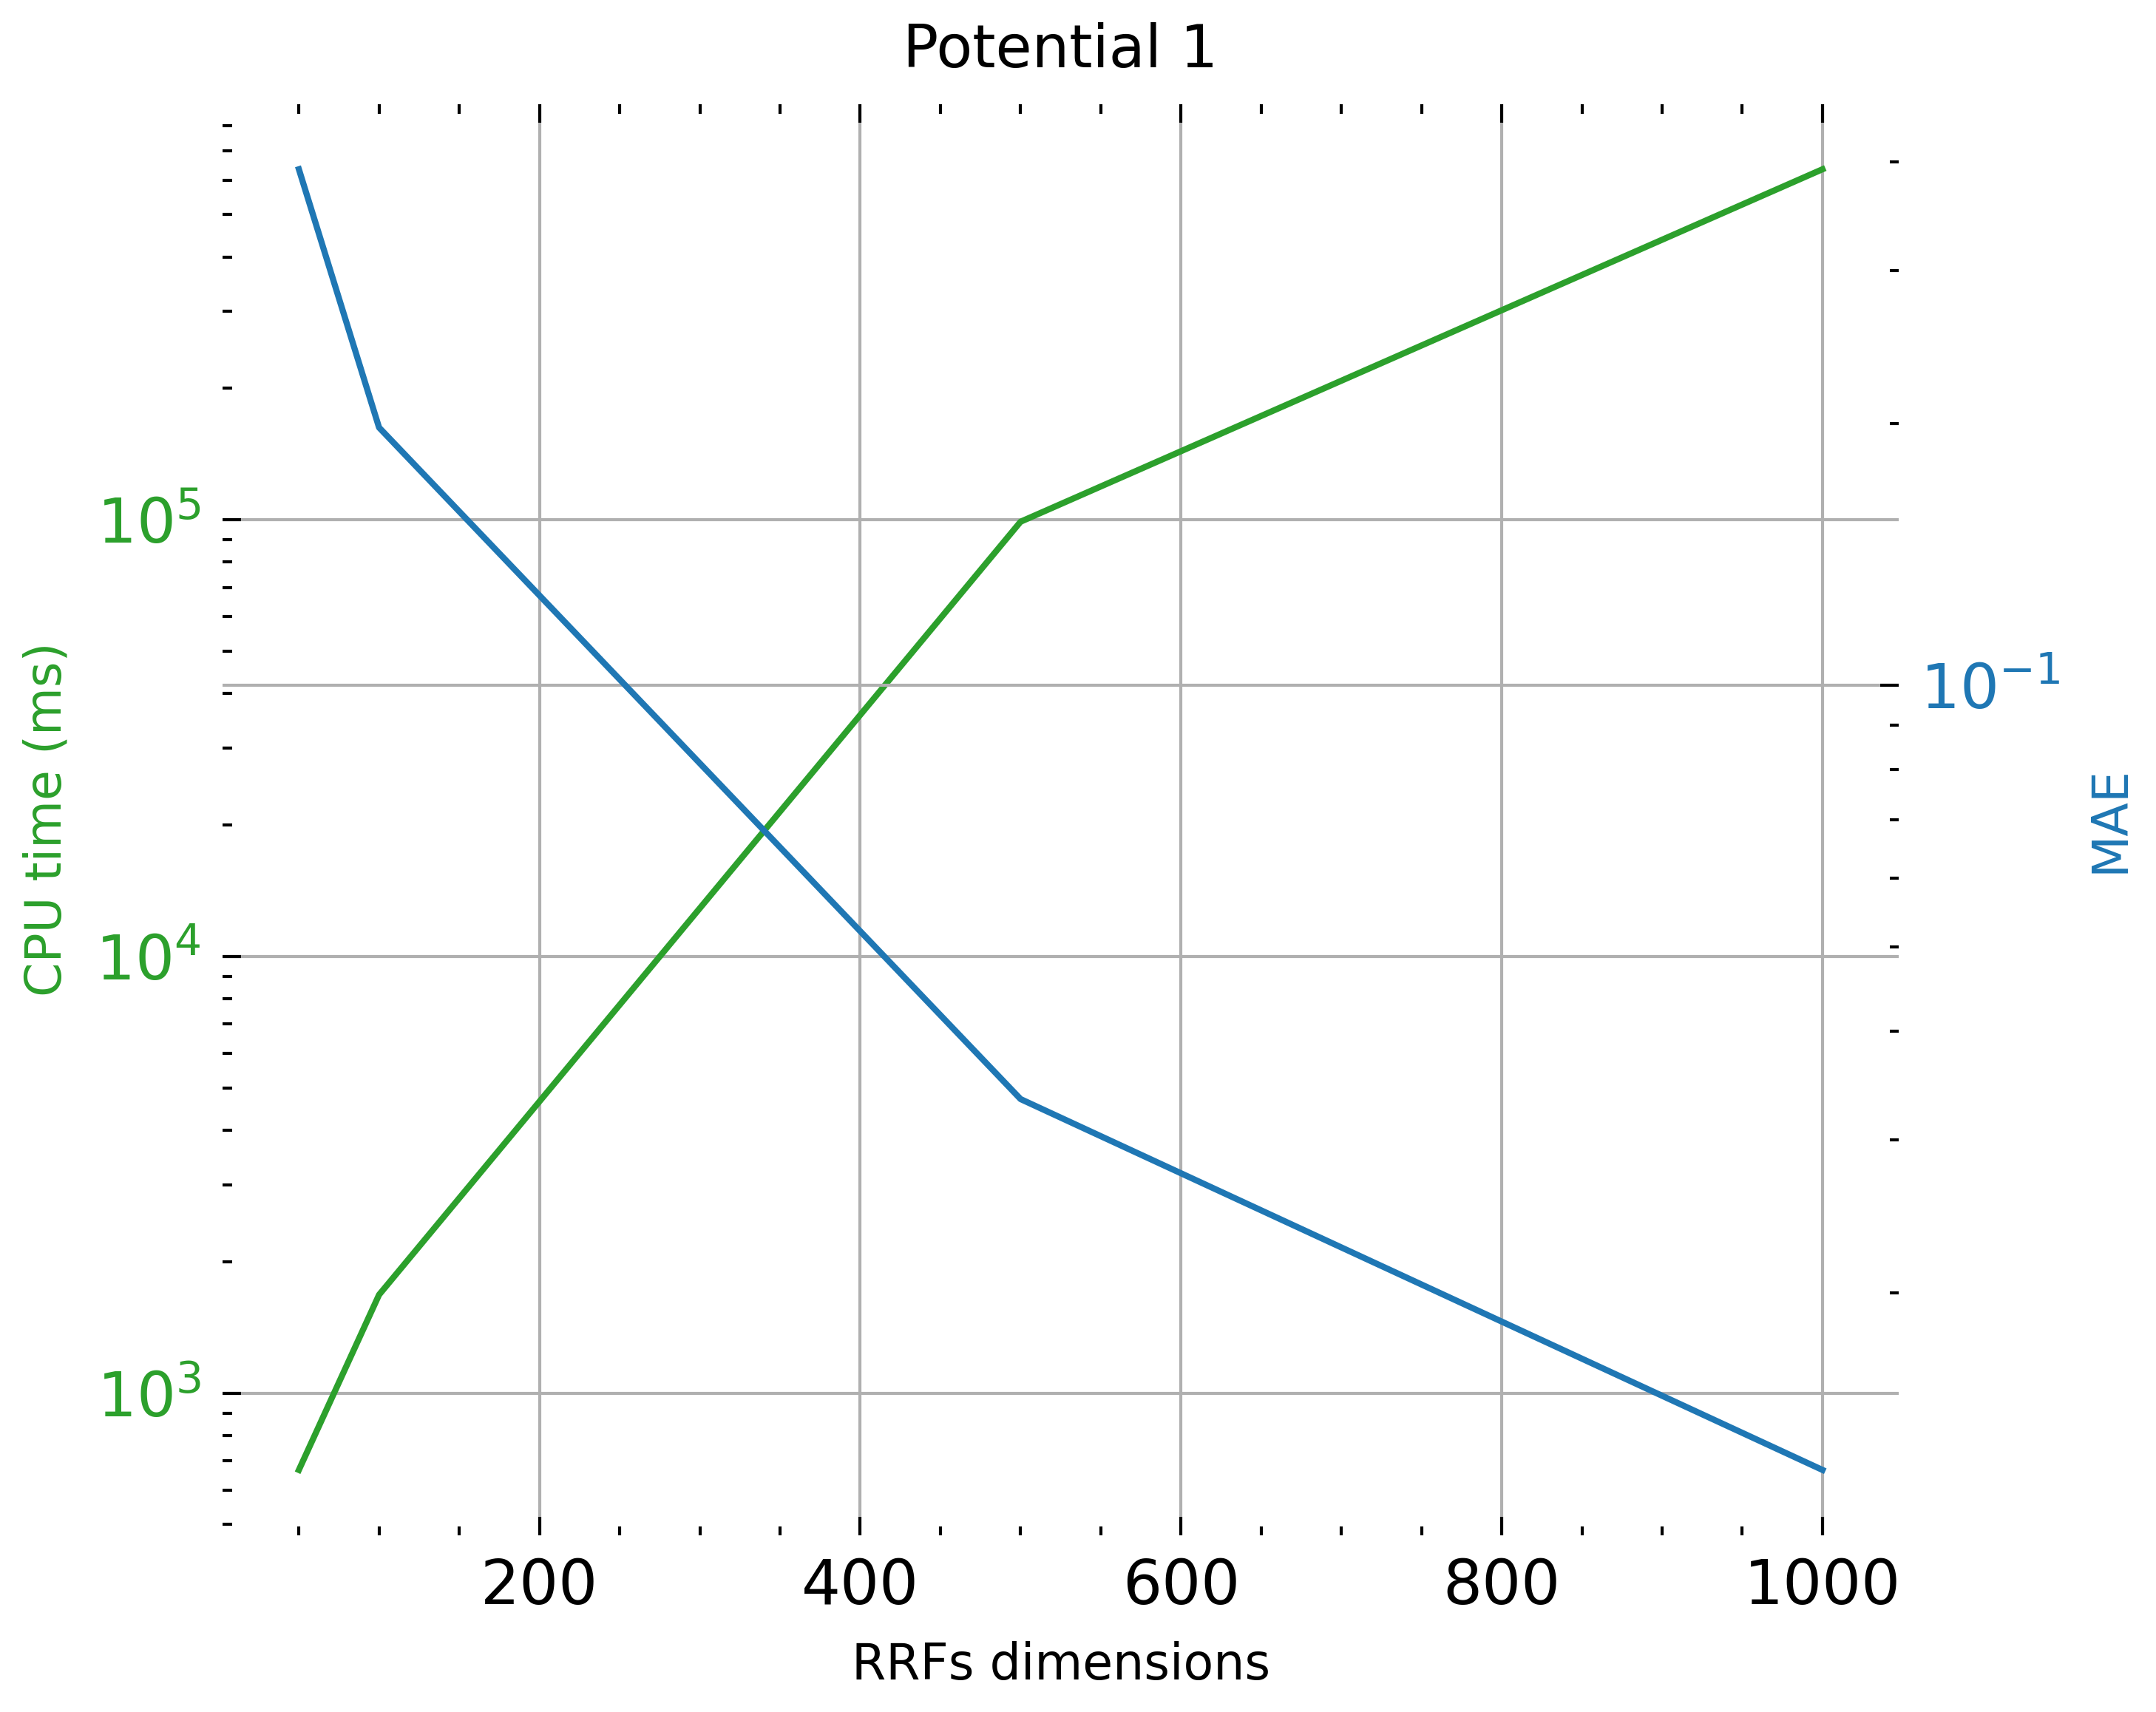

In [18]:
#EIG_DMKDE_50
CPU_time_EIG_DMKDE_50 = [482,494,495,499,492][4]
#EIG_DMKDE_100
CPU_time_EIG_DMKDE_100 = [496,539,535,511,561][4]
#EIG_DMKDE_500
CPU_time_EIG_DMKDE_500 = [541,788,1850,3610,3640][4]
#EIG_DMKDE_1000
CPU_time_EIG_DMKDE_1000 = [776,987,2730,10800,10800][4]

#EIG_DMKDE_50
error_EIG_DMKDE_50 = [0.0575,0.0809,0.1881,0.3927,0.3926][4]
#EIG_DMKDE_100
error_EIG_DMKDE_100 = [0.0596,0.0540,0.0946,0.1979,0.1980][4]
#EIG_DMKDE_500
error_EIG_DMKDE_500 = [0.0574,0.0324,0.0197,0.0337,0.0334][4]
#EIG_DMKDE_1000
error_EIG_DMKDE_1000 = [0.0575,0.0327,0.0178,0.0144,0.0125][4]
t = [50.,100.,500.,1000.]
data1 = [CPU_time_DMKDE_50,CPU_time_DMKDE_100,CPU_time_DMKDE_500,CPU_time_DMKDE_1000]
data2 = [error_EIG_DMKDE_50,error_EIG_DMKDE_100,error_EIG_DMKDE_500,error_EIG_DMKDE_1000]

fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_title('Potential 1')
ax1.grid(True)
ax1.spines["bottom"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.set_xlabel('RRFs dimensions')
ax1.set_ylabel('CPU time (ms)', color=color)
ax1.set_yscale('log')
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.grid(True)
ax2.spines["bottom"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.set_ylabel('MAE', color=color)  # we already handled the x-label with ax1
ax2.set_yscale('log')
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig('rff_pot1.png', dpi=300)
plt.show()